# Senior Project: AI vs Human Text

TO DO: Senior Project
---------------------------------------------------------------------------------

Analysis
-----------------------------------------------------
-- Finish Gathering AI Essays
-- Split The Data?
-- Finish Verb, Adjective, Conjunction Frequency Analysis. Maybe Nouns?




Machine Learning Model
------------------------------------------------------
-- Compile Important Features: word_count, lexical_diversity, word_length, stopword_frequency, pronoun_count, types of pronouns, nouns, types of nouns etc..

--Determine and Finish Collection of Labels: Split the Data, or Gather More?

--Implement Random Forest Learning Algorithm for Classification


Presentation
------------------------------------------------------
-- Catelog Research/Findings
	** Process, Shortcomings, Successes, Does it Work?
	** Keep Track of Libraries, Types of Text
-- Slide Show
-- Presentation

---------------DONE??-------------

## Data Collection

For AI
------------------------------------------------------
--Chatgpt 4 & ChatGPT 3.5 Essays compiled from random or given prompts on any subject

For Human
-------------------------------------------------------
--Old Essays of Mine, Siblings, and Friends. All College level Writing. Not Professional Works.

## Early Collection of Metadata and Basic Cleaning Functions

!pip install python-docx

In [16]:
import docx
from docx import Document
from collections import Counter
import nltk
import os
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, mannwhitneyu

def get_word_count(tokens):
    return len(tokens)

def get_sentence_count(text):
    sentences = re.split(r'[.!?]+', text)
    return len([s for s in sentences if s.strip()])

def get_avg_word_length(tokens):
    if tokens:
        return sum(len(word) for word in tokens) / len(tokens)
    else:
        return 0

def get_paragraph_count(text):
    paragraphs = text.split('\n\n')
    return len([p for p in paragraphs if p.strip()])

def get_lexical_diversity(tokens):
    unique_words = set(tokens)
    if tokens:
        return len(unique_words) / len(tokens)
    else:
        return 0

def remove_after_works_cited(text):
    lower_text = text.lower()
    reference_headings = ["works cited", "references", "bibliography", "reference list"]
    for heading in reference_headings:
        index = lower_text.find(heading)
        if index != -1:
            return text[:index]
    return text

def preprocess_text(text):
    text = remove_after_works_cited(text)
    text = re.sub(r'\n', ' ', text)  # Remove new line characters
    text = re.sub(r"[,.!?;:\"“”()\-—[\]{}<>@#$%^&*+=/\\|~`0-9]+", '', text)  # Remove all punctuation, strange characters and numbers
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    return tokens

def docx_to_text_and_metadata(path, label):
    doc = Document(path)
    raw_text = '\n\n'.join(paragraph.text for paragraph in doc.paragraphs)
    cleaned_text = preprocess_text(raw_text)
    
    title = doc.core_properties.title
    subject = doc.core_properties.subject

    comma_count = raw_text.count(',')
    word_count = get_word_count(cleaned_text)
    sentence_count = get_sentence_count(raw_text)
    avg_word_length = get_avg_word_length(cleaned_text)
    paragraph_count = get_paragraph_count(raw_text)
    lexical_diversity = get_lexical_diversity(cleaned_text)
    
    return {
        'raw_text': raw_text,
        'text': ' '.join(cleaned_text),
        'title': title,
        'subject': subject,
        'comma_count': comma_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'paragraph_count': paragraph_count,
        'lexical_diversity': lexical_diversity,
        'file_name': os.path.basename(path),
        'label': label
    }

def process_essays_directory(docs_dir, label):
    doc_files = [f for f in os.listdir(docs_dir) if f.endswith('.docx')]
    docs_data = []
    for file_name in doc_files:
        file_path = os.path.join(docs_dir, file_name)
        doc_data = docx_to_text_and_metadata(file_path, label)
        docs_data.append(doc_data)
    return docs_data

# Path variables for essays
human_docs_dir = r'C:\Users\Colin\OneDrive\Desktop\Senior Project Code\Senior-Project\Human_Essays'
ai_docs_dir = r'C:\Users\Colin\OneDrive\Desktop\Senior Project Code\Senior-Project\AI_Essays'

# Process each directory with the appropriate label
human_docs_data = process_essays_directory(human_docs_dir, 'Human')
ai_docs_data = process_essays_directory(ai_docs_dir, 'AI')
all_docs_data = human_docs_data + ai_docs_data
df_all_docs = pd.DataFrame(all_docs_data)
df_all_docs.to_csv('combined_docs_with_metadata.csv', index=False, encoding='utf-8-sig')

print("Document data exported to 'combined_docs_with_metadata.csv'.")

Document data exported to 'combined_docs_with_metadata.csv'.


## Find Directory where .csv File is Stored

In [91]:
import os

current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: C:\Users\Colin


## Retrieve Lexical Statistics

### Before Cleaning Word Count

In [92]:
def raw_word_count(text):
    words = re.split(r'\s+', text)
    words = [word for word in words if word]
    return len(words)

ai_raw_word_count = 0
human_raw_word_count = 0

for index, row in df_all_docs.iterrows():
    word_count = raw_word_count(row['raw_text'])
    if row['label'] == 'AI':
        ai_raw_word_count += word_count
    elif row['label'] == 'Human':
        human_raw_word_count += word_count

print(f"Total raw word count for AI essays: {ai_raw_word_count}")
print(f"Total raw word count for Human essays: {human_raw_word_count}")

Total raw word count for AI essays: 46083
Total raw word count for Human essays: 57180


### After Cleaning Word Count

In [93]:
ai_word_count = 0
human_word_count = 0

for index, row in df_all_docs.iterrows():
    words = preprocess_text(row['text']) 
    if row['label'] == 'AI':
        ai_word_count += len(words)
    elif row['label'] == 'Human':
        human_word_count += len(words)

print(f"Cleaned total word count for AI essays: {ai_word_count}")
print(f"Cleaned total word count for Human essays: {human_word_count}")

Cleaned total word count for AI essays: 44051
Cleaned total word count for Human essays: 54847


## Attempt Visualization of All Most Frequent Words

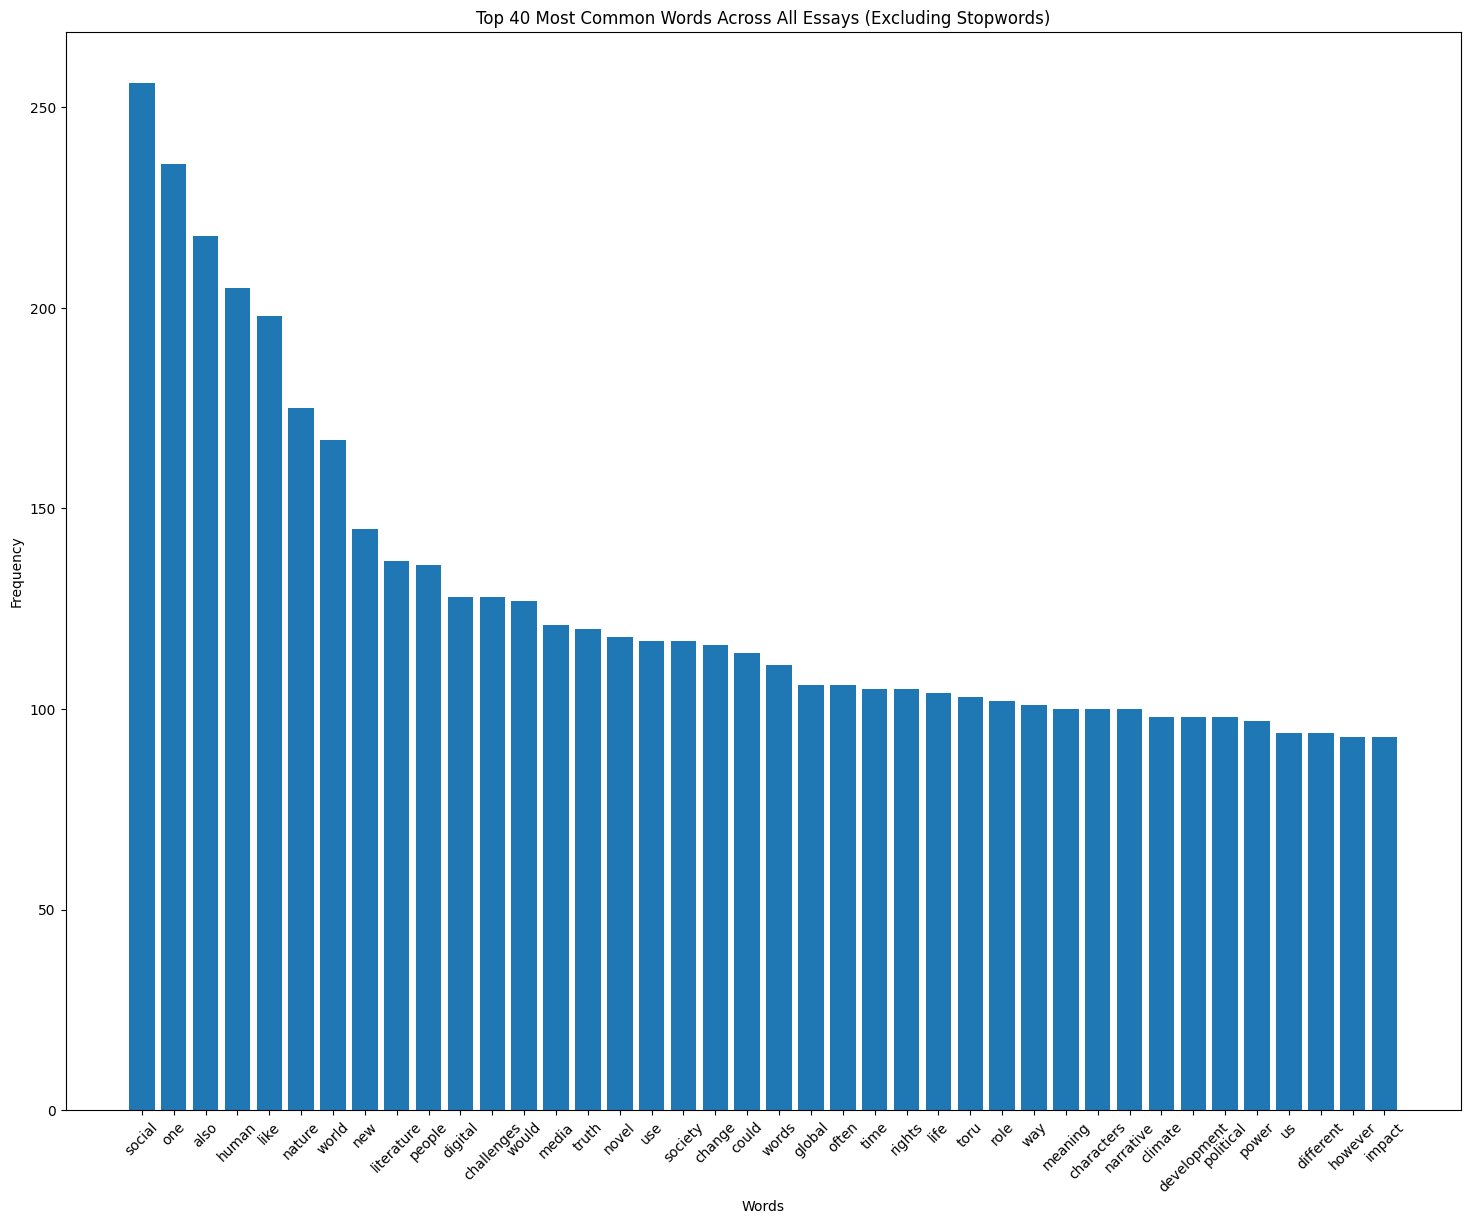

In [31]:
english_stopwords = set(stopwords.words('english'))

all_words = [
    word for essay in df_all_docs['text']
    for word in word_tokenize(essay)
    if word not in english_stopwords and word.isalpha()
]

freq_dist = FreqDist(all_words)
most_common_words = freq_dist.most_common(40)
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(18, 14))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 40 Most Common Words Across All Essays (Excluding Stopwords)')
plt.show()

## Visualization Popular Word Frequency AI vs. Human

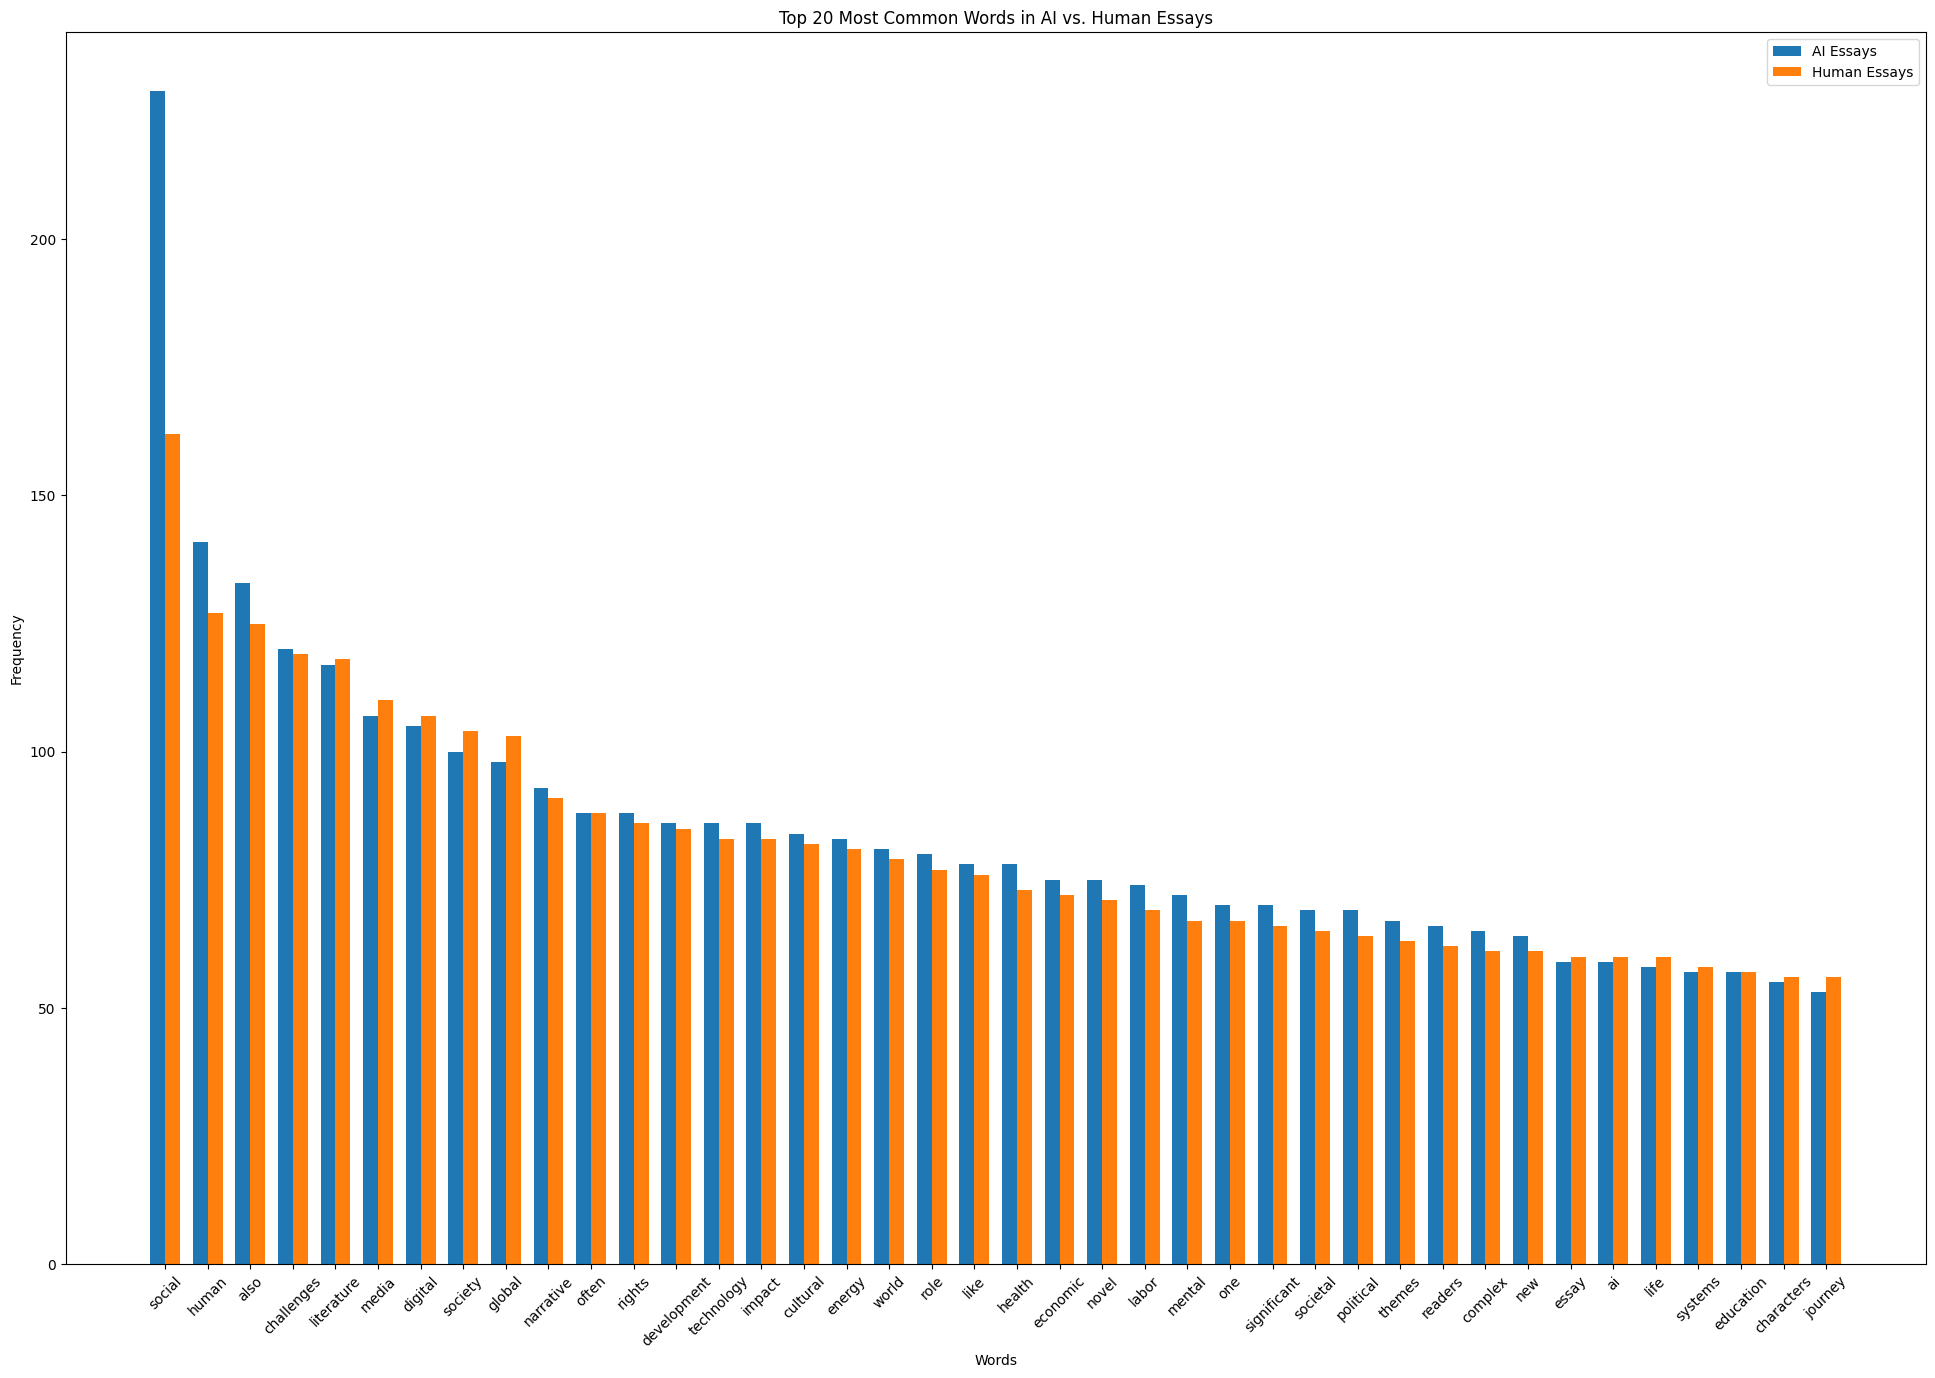

In [6]:
english_stopwords = set(stopwords.words('english'))

ai_essays = df_all_docs[df_all_docs['label'] == 'AI']['text']
human_essays = df_all_docs[df_all_docs['label'] == 'Human']['text']
ai_words = []
human_words = []

for essay in ai_essays:
    words = preprocess_text(essay)
    filtered_words = [word for word in words if word not in english_stopwords and word.isalpha()]
    ai_words.extend(filtered_words)

for essay in human_essays:
    words = preprocess_text(essay)
    filtered_words = [word for word in words if word not in english_stopwords and word.isalpha()]
    human_words.extend(filtered_words)

ai_freq_dist = FreqDist(ai_words)
human_freq_dist = FreqDist(human_words)

ai_common_words = ai_freq_dist.most_common(40)
human_common_words = human_freq_dist.most_common(40)

# Unpack words and frequencies
ai_words, ai_frequencies = zip(*ai_common_words)
human_words, human_frequencies = zip(*human_common_words)

# Create an index for each tick position
ind = np.arange(len(ai_common_words))
width = 0.35 
fig, ax = plt.subplots(figsize=(24, 16))

ai_bars = ax.bar(ind - width/2, ai_frequencies, width, label='AI Essays')
human_bars = ax.bar(ind + width/2, human_frequencies, width, label='Human Essays')
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Most Common Words in AI vs. Human Essays')
ax.set_xticks(ind)
ax.set_xticklabels(ai_words, rotation=45)  # Rotate labels for better readability
ax.legend()

plt.show()

AI Essays Average Lexical Diversity: 0.484
Human Essays Average Lexical Diversity: 0.377



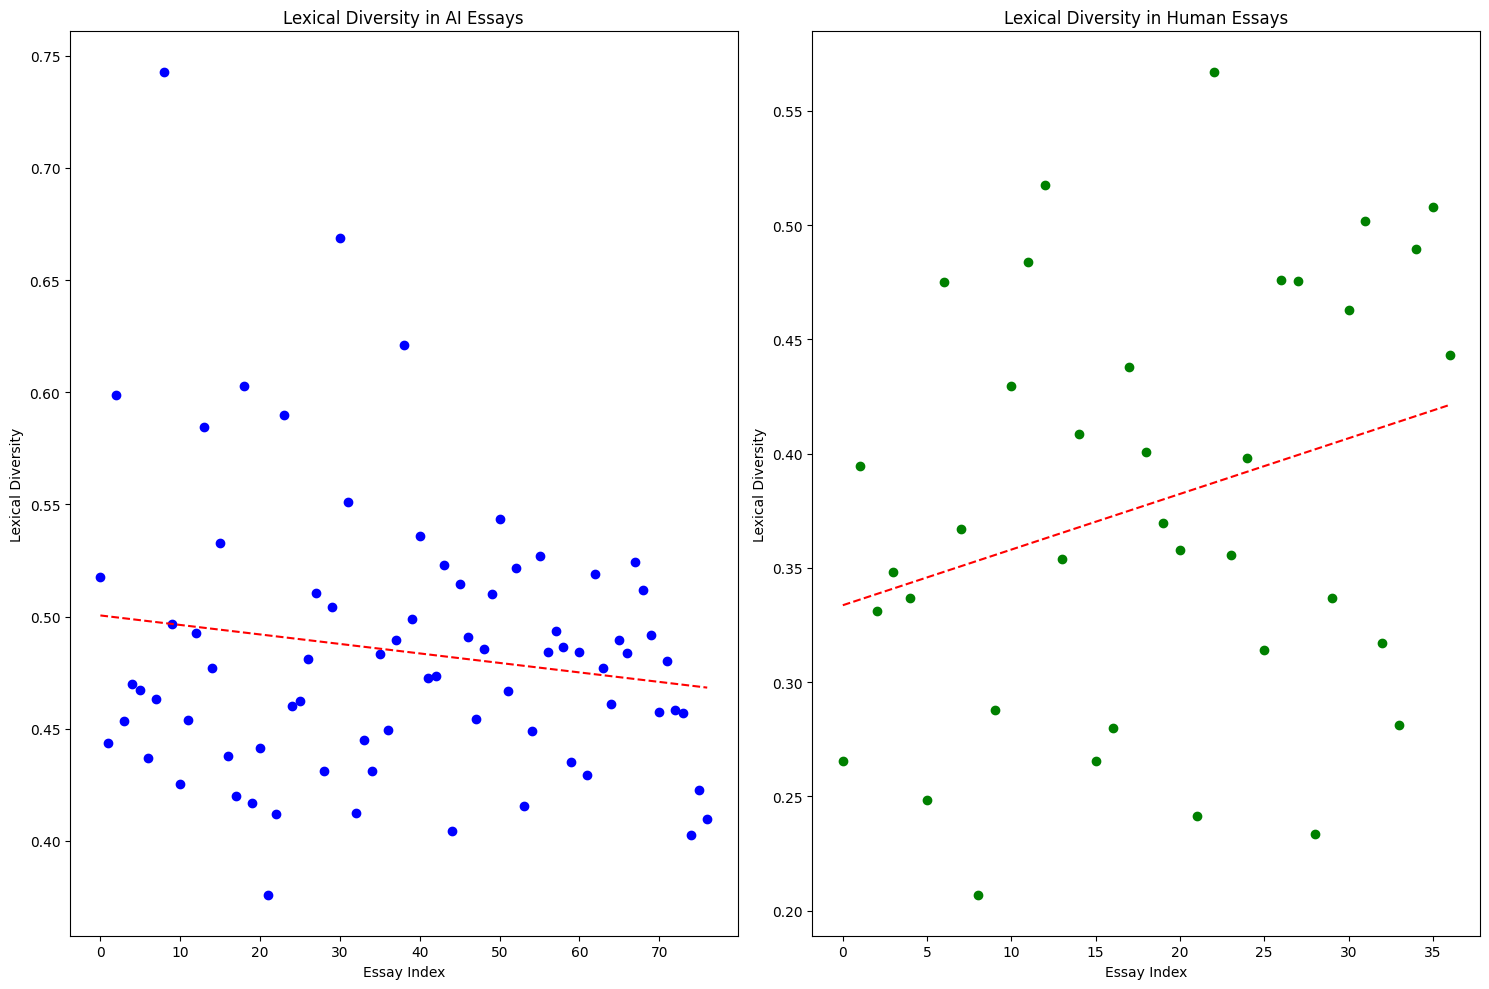

In [33]:
def lexical_diversity(text):
    tokens = preprocess_text(text)
    return len(set(tokens)) / len(tokens) if tokens else 0

# Calculate lexical diversity for each essay
ai_diversities = [lexical_diversity(essay) for essay in ai_essays]
human_diversities = [lexical_diversity(essay) for essay in human_essays]
ai_lexical_average = np.mean(ai_diversities)
human_lexical_average = np.mean(human_diversities)

print(f"AI Essays Average Lexical Diversity: {ai_lexical_average:.3f}")
print(f"Human Essays Average Lexical Diversity: {human_lexical_average:.3f}\n")

plt.figure(figsize=(15, 10))

# AI Essays
plt.subplot(1, 2, 1)
plt.scatter(range(len(ai_diversities)), ai_diversities, color='blue', label='AI')
z = np.polyfit(range(len(ai_diversities)), ai_diversities, 1)
p = np.poly1d(z)
plt.plot(range(len(ai_diversities)), p(range(len(ai_diversities))), "r--")
plt.title("Mean Lexical Diversity in AI Essays")
plt.xlabel("Essay Index")
plt.ylabel("Lexical Diversity")

# Human Essays
plt.subplot(1, 2, 2)
plt.scatter(range(len(human_diversities)), human_diversities, color='green', label='Human')
z = np.polyfit(range(len(human_diversities)), human_diversities, 1)
p = np.poly1d(z)
plt.plot(range(len(human_diversities)), p(range(len(human_diversities))), "r--")
plt.title("Mean Lexical Diversity in Human Essays")
plt.xlabel("Essay Index")
plt.ylabel("Lexical Diversity")

plt.tight_layout()
plt.show()

## Frequency of Stop/Junk Words

AI Essays Stopwords: 15901 (36.10%)
Human Essays Stopwords: 26675 (47.92%)


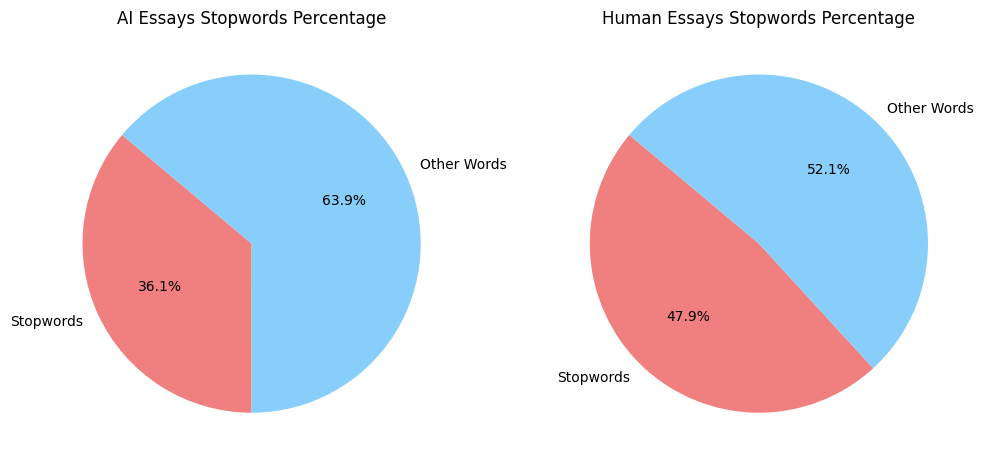

In [34]:
def stopword_analysis(ai_essays, human_essays):
    english_stopwords = set(stopwords.words('english'))
    
    # Concatenate all texts in each Series into a single string
    ai_combined_text = ' '.join(ai_essays).lower()
    human_combined_text = ' '.join(human_essays).lower()
    
    # Tokenize the combined texts
    ai_tokens = word_tokenize(ai_combined_text)
    human_tokens = word_tokenize(human_combined_text)
    
    # Filter out stopwords
    ai_stopwords = [token for token in ai_tokens if token in english_stopwords]
    human_stopwords = [token for token in human_tokens if token in english_stopwords]
    
    # Count stopwords and total words
    ai_stopwords_count = len(ai_stopwords)
    human_stopwords_count = len(human_stopwords)
    total_ai_words = len(ai_tokens)
    total_human_words = len(human_tokens)
    
    # Calculate stopwords percentage
    ai_stopwords_percentage = (ai_stopwords_count / total_ai_words) * 100
    human_stopwords_percentage = (human_stopwords_count / total_human_words) * 100

    # Print number of stopwords and percentages
    print(f"AI Essays Stopwords: {ai_stopwords_count} ({ai_stopwords_percentage:.2f}%)")
    print(f"Human Essays Stopwords: {human_stopwords_count} ({human_stopwords_percentage:.2f}%)")
    
    # Plot pie charts
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    labels = ['Stopwords', 'Other Words']
    ai_sizes = [ai_stopwords_percentage, 100 - ai_stopwords_percentage]
    human_sizes = [human_stopwords_percentage, 100 - human_stopwords_percentage]
    colors = ['lightcoral', 'lightskyblue']
    
    axs[0].pie(ai_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axs[0].set_title('AI Essays Stopwords Percentage')
    
    axs[1].pie(human_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axs[1].set_title('Human Essays Stopwords Percentage')
    
    plt.show()

# Assuming ai_essays and human_essays are already defined in your code
stopword_analysis(ai_essays, human_essays)

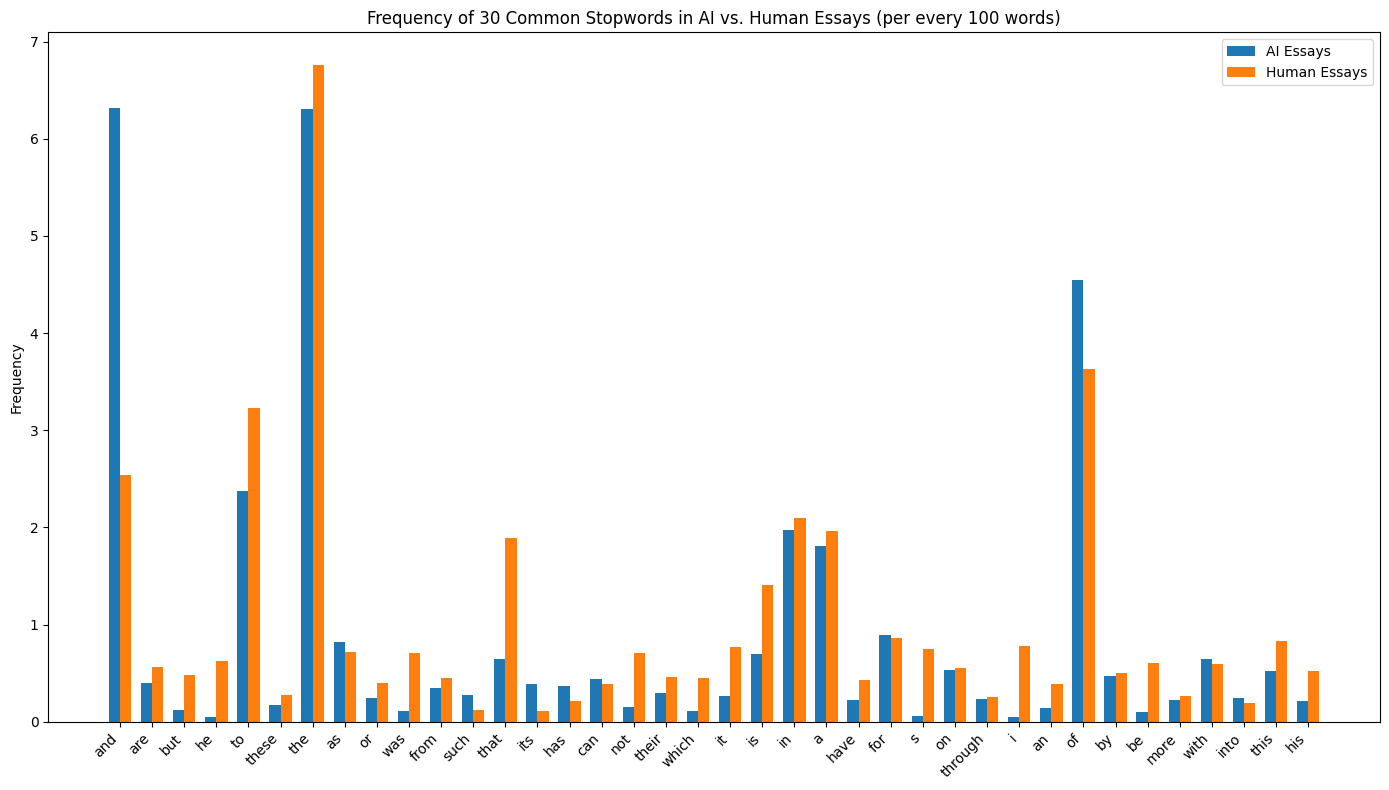

In [11]:
english_stopwords = set(stopwords.words('english'))

def get_stopword_frequencies(texts):
    stopwords_counter = Counter()
    total_words = 0

    for text in texts:
        tokens = word_tokenize(text.lower())
        total_words += len([token for token in tokens if token.isalpha()])  # Counting only alphabetic words
        stopwords_counter.update([token for token in tokens if token in english_stopwords and token.isalpha()])

    return stopwords_counter, total_words

ai_stopwords, ai_total_words = get_stopword_frequencies(df_all_docs[df_all_docs['label'] == 'AI']['text'])
human_stopwords, human_total_words = get_stopword_frequencies(df_all_docs[df_all_docs['label'] == 'Human']['text'])

# Identify common stopwords for comparison
common_stopwords = set([word for word, count in ai_stopwords.most_common(30)] + [word for word, count in human_stopwords.most_common(30)])
plot_data = {word: [
    (ai_stopwords[word] / ai_total_words) * 100,
    (human_stopwords[word] / human_total_words) * 100 ] for word in common_stopwords}

words = list(plot_data.keys())
ai_freqs = [plot_data[word][0] for word in words]
human_freqs = [plot_data[word][1] for word in words]

x = np.arange(len(words)) 
width = 0.35 
fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, ai_freqs, width, label='AI Essays')
rects2 = ax.bar(x + width/2, human_freqs, width, label='Human Essays')

ax.set_ylabel('Frequency')
ax.set_title('Frequency of 30 Common Stopwords in AI vs. Human Essays (per every 100 words)')
ax.set_xticks(x)
ax.set_xticklabels(words, rotation=45, ha='right')
ax.legend()
fig.tight_layout()

plt.show()

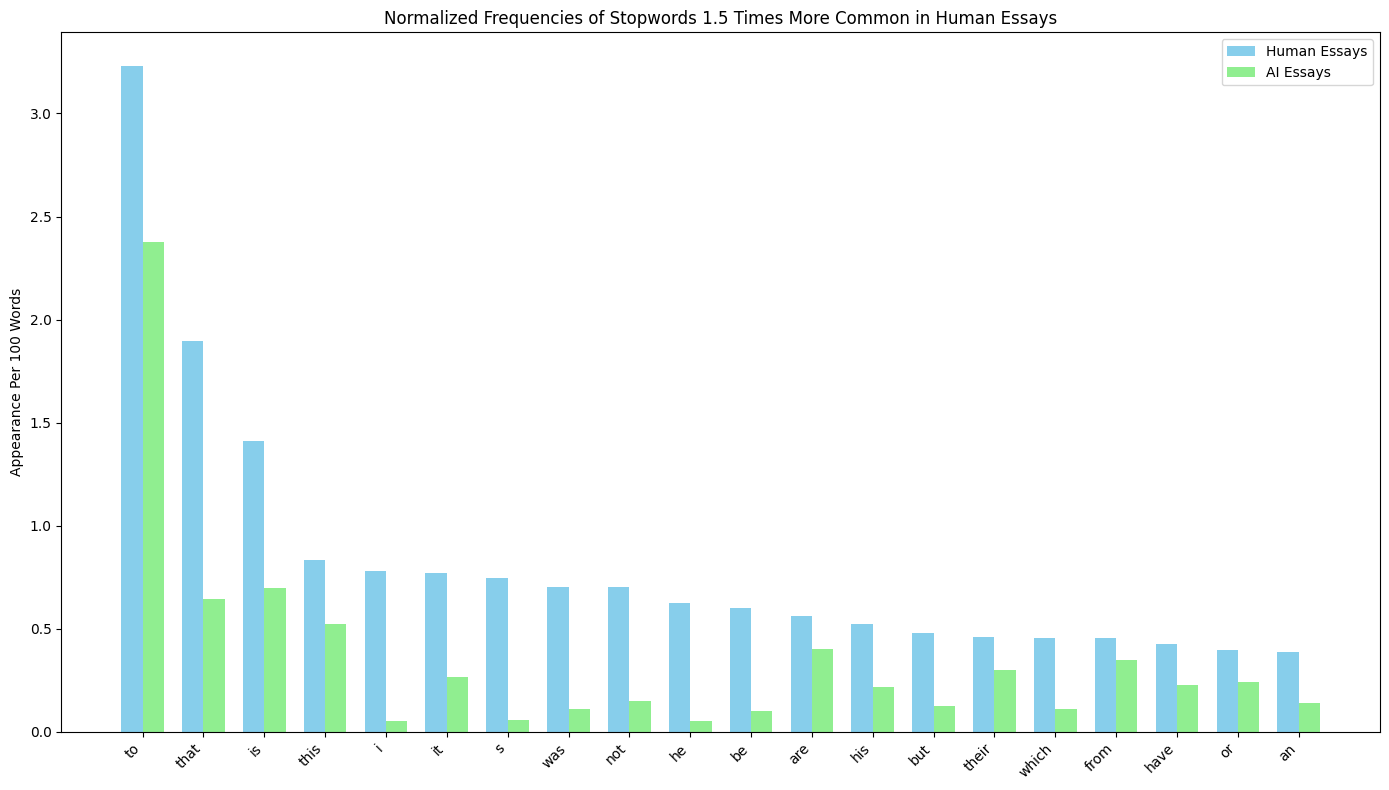

In [14]:
# Look for stopwords where human usage is at least 1.5 times of AI
significant_stopwords = {word: freq for word, freq in human_stopwords.items() if freq > 1.5 * ai_stopwords.get(word, 0)}

# Sort human stopwords by frequency and get the top 20
significant_stopwords_sorted = sorted(significant_stopwords.items(), key=lambda x: x[1], reverse=True)[:20]
words, human_freqs = zip(*significant_stopwords_sorted)

# Get the corresponding AI frequencies for the significant words
ai_freqs = [ai_stopwords[word] for word in words]

# Normalize the frequencies by total words count
human_normalized_freqs = [(freq / human_total_words) * 100 for freq in human_freqs]
ai_normalized_freqs = [(freq / ai_total_words) * 100 for freq in ai_freqs]

x = np.arange(len(words))
width = 0.35
fig, ax = plt.subplots(figsize=(14, 8))

# Plot normalized frequencies
ax.bar(x - width/2, human_normalized_freqs, width, label='Human Essays', color='skyblue')
ax.bar(x + width/2, ai_normalized_freqs, width, label='AI Essays', color='lightgreen')

ax.set_ylabel('Appearance Per 100 Words')
ax.set_title('Normalized Frequencies of Stopwords 1.5 Times More Common in Human Essays')
ax.set_xticks(x)
ax.set_xticklabels(words, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()

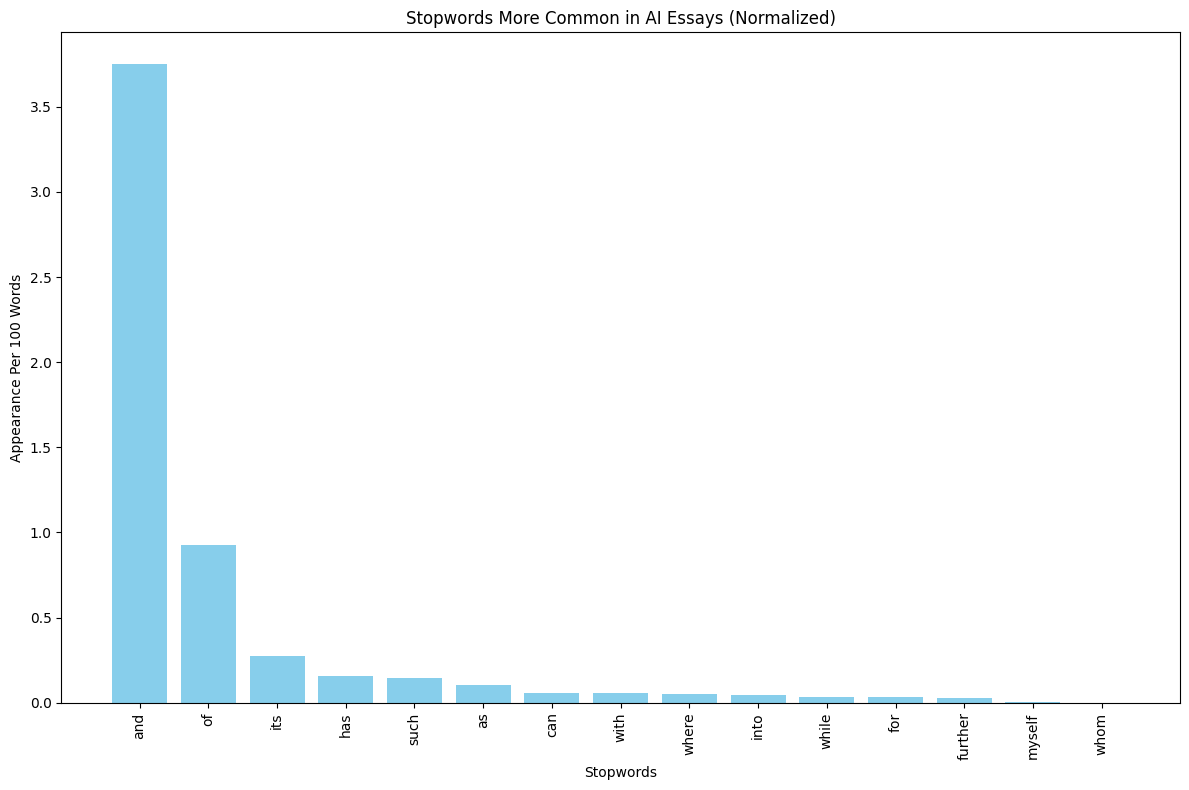

In [17]:
def get_normalized_stopword_counts(texts):
    stopword_counts = Counter()
    total_words = sum(len(word_tokenize(text)) for text in texts)
    
    for text in texts:
        stopword_counts.update(word for word in word_tokenize(text.lower()) if word in stopwords.words('english'))
    
    normalized_stopword_counts = {word: (count / total_words) * 100 for word, count in stopword_counts.items()}
    return normalized_stopword_counts

ai_stopword_counts = get_normalized_stopword_counts(ai_essays)
human_stopword_counts = get_normalized_stopword_counts(human_essays)

# Identify stopwords more common in AI and calculate the difference
ai_more_common_stopwords = {word: ai_stopword_counts[word] - human_stopword_counts.get(word, 0)
                            for word in ai_stopword_counts
                            if ai_stopword_counts[word] > human_stopword_counts.get(word, 0)}

sorted_ai_more_common_stopwords = sorted(ai_more_common_stopwords.items(), key=lambda x: x[1], reverse=True)
stopwords, differences = zip(*sorted_ai_more_common_stopwords)

plt.figure(figsize=(12, 8))
plt.bar(stopwords, differences, color='skyblue')
plt.xlabel('Stopwords')
plt.ylabel('Appearance Per 100 Words')
plt.title('Stopwords More Common in AI Essays (Normalized)')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

conditional probabilities represent the likelihood of encountering each stopword in a single word drawn randomly from the text corpus of the specified category

Number of Stopwords With Higher Probability of Encountering in AI Essays: 15


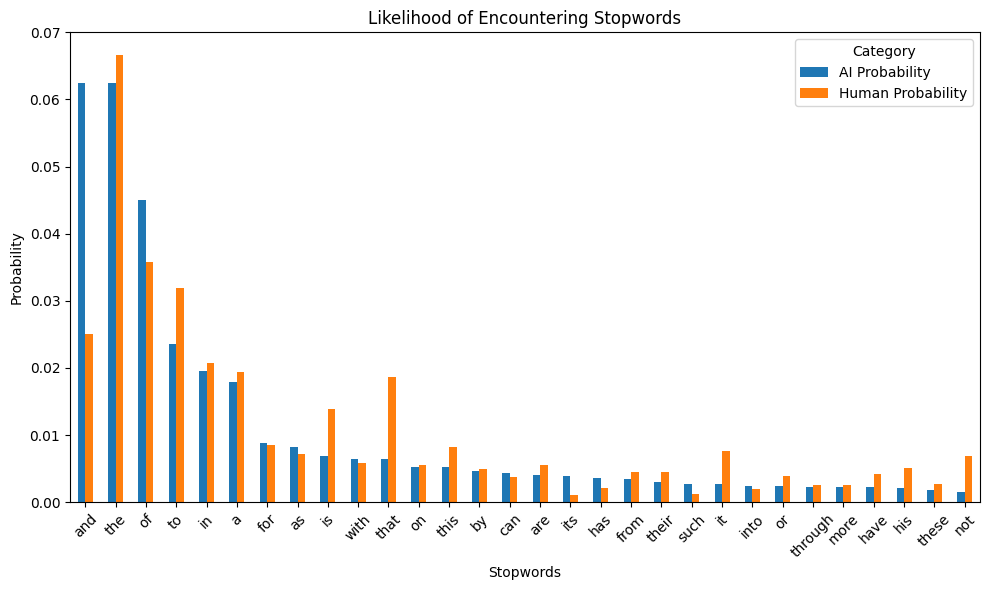

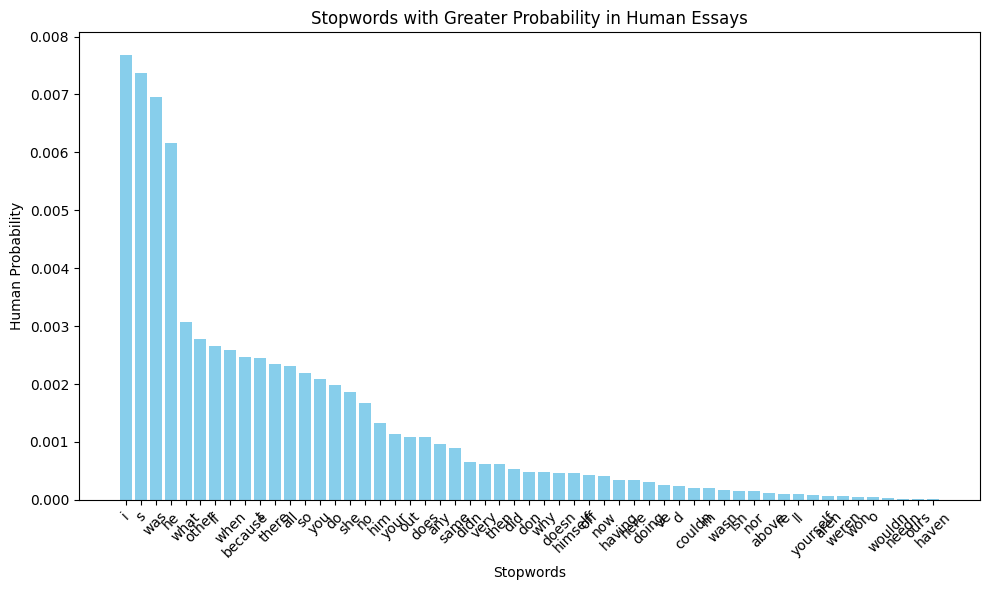

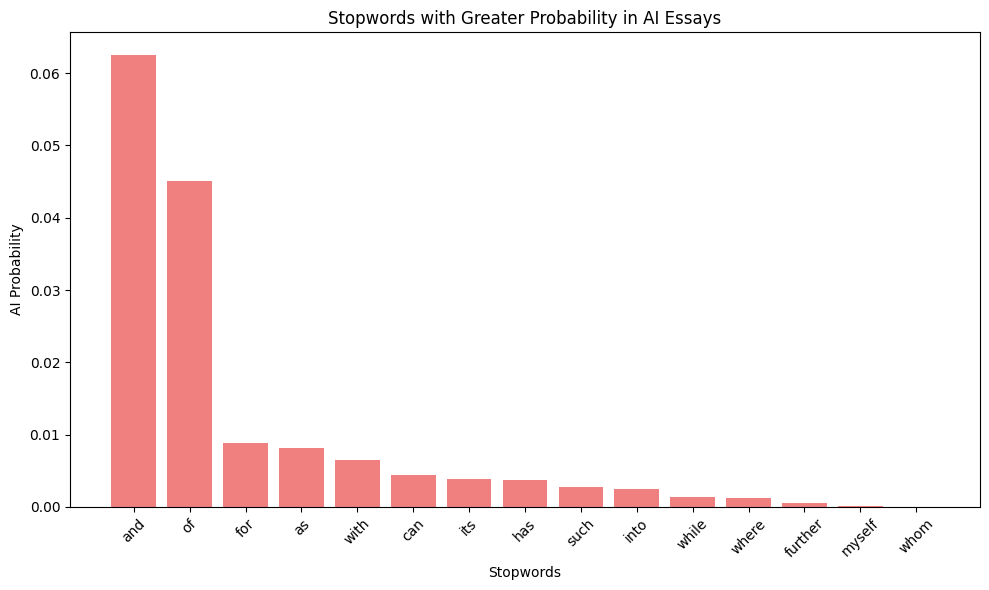

   Stopword  AI Probability  Human Probability
0       and        0.062518           0.025025
1       the        0.062428           0.066668
2        of        0.045061           0.035804
3        to        0.023541           0.031888
4        in        0.019523           0.020732
5         a        0.017911           0.019366
6       for        0.008853           0.008533
7        as        0.008172           0.007114
8        is        0.006901           0.013905
9      with        0.006424           0.005875
10     that        0.006379           0.018701
11       on        0.005312           0.005479
12     this        0.005176           0.008228
13       by        0.004699           0.004922
14      can        0.004404           0.003809
15      are        0.003995           0.005533
16      its        0.003882           0.001132
17      has        0.003655           0.002084
18     from        0.003451           0.004473
19    their        0.002951           0.004545
20     such  

In [40]:
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

english_stopwords = set(stopwords.words('english'))

def calculate_conditional_probabilities(df, category):
    category_essays = df[df['label'] == category]['text']
    total_words = sum(len(word_tokenize(text)) for text in category_essays)
    stopword_counter = Counter()
    for text in category_essays:
        tokens = word_tokenize(text.lower())
        stopword_counter.update(token for token in tokens if token in english_stopwords)
    
    conditional_probabilities = {word: freq / total_words for word, freq in stopword_counter.items()}
    
    return conditional_probabilities

cond_prob_stopword_ai = calculate_conditional_probabilities(df_all_docs, 'AI')
cond_prob_stopword_human = calculate_conditional_probabilities(df_all_docs, 'Human')

english_stopwords_freq = {word: freq for word, freq in cond_prob_stopword_ai.items() if word in english_stopwords}
english_stopwords_sorted = sorted(english_stopwords_freq.items(), key=lambda x: x[1], reverse=True)[:30]
english_stopwords_selected = [word for word, _ in english_stopwords_sorted]

stopwords_data = {'Stopword': english_stopwords_selected,
                  'AI Probability': [cond_prob_stopword_ai.get(word, 0) for word in english_stopwords_selected],
                  'Human Probability': [cond_prob_stopword_human.get(word, 0) for word in english_stopwords_selected]}
stopwords_df = pd.DataFrame(stopwords_data)

ai_more_stopwords = {word: freq for word, freq in cond_prob_stopword_ai.items() if freq > cond_prob_stopword_human.get(word, 0)}
num_ai_more_stopwords = len(ai_more_stopwords)


print(f"Number of Stopwords With Higher Probability of Encountering in AI Essays: {num_ai_more_stopwords}")


fig, ax = plt.subplots(figsize=(10, 6))
stopwords_df.plot(x='Stopword', y=['AI Probability', 'Human Probability'], kind='bar', ax=ax)
ax.set_xlabel('Stopwords')
ax.set_ylabel('Probability')
ax.set_title('Likelihood of Encountering Stopwords')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

# Stopwords With Probability 6 Times More In Human
human_significant_stopwords = {word: freq for word, freq in cond_prob_stopword_human.items() if freq > 6.0 * cond_prob_stopword_ai.get(word, 0)}
human_significant_stopwords_sorted = sorted(human_significant_stopwords.items(), key=lambda x: x[1], reverse=True)
words, human_probabilities = zip(*human_significant_stopwords_sorted)

# Human Bar Graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(words, human_probabilities, color='skyblue')
ax.set_xlabel('Stopwords')
ax.set_ylabel('Human Probability')
ax.set_title('Stopwords with Greater Probability in Human Essays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ai_significant_stopwords = {word: freq for word, freq in cond_prob_stopword_ai.items() if freq > cond_prob_stopword_human.get(word, 0)}
ai_significant_stopwords_sorted = sorted(ai_significant_stopwords.items(), key=lambda x: x[1], reverse=True)
ai_words, ai_probabilities = zip(*ai_significant_stopwords_sorted)

# AI Bar Graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ai_words, ai_probabilities, color='lightcoral')
ax.set_xlabel('Stopwords')
ax.set_ylabel('AI Probability')
ax.set_title('Stopwords with Greater Probability in AI Essays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(stopwords_df)

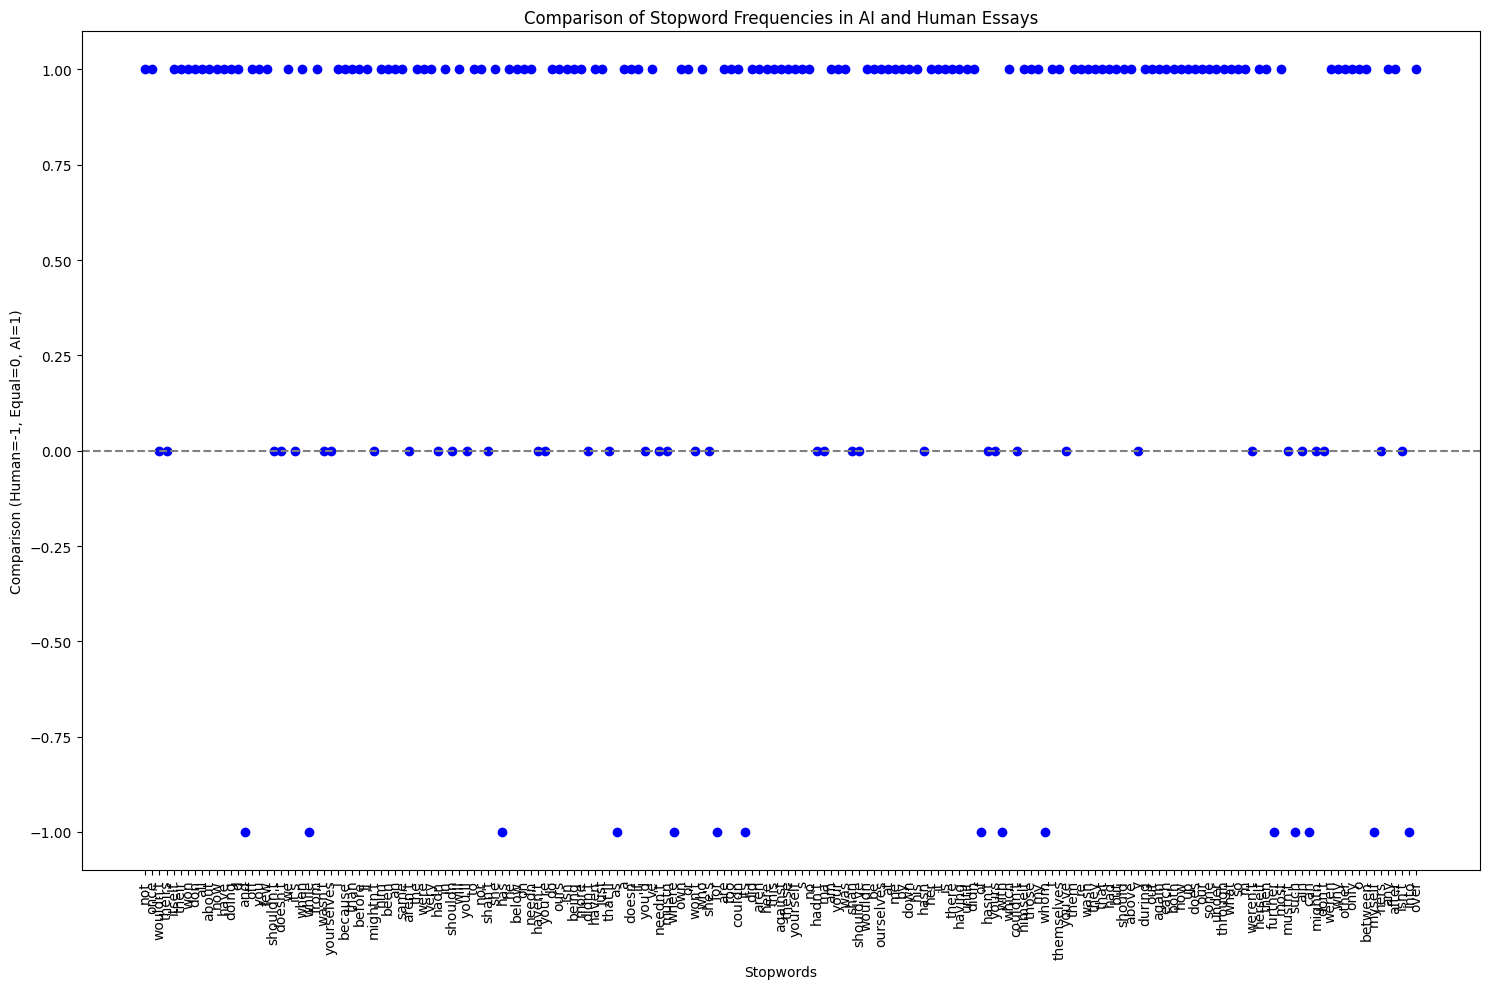

In [47]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

stopwords_data = []
for stopword in english_stopwords:
    ai_freq = ai_stopword_counts.get(stopword, 0)
    human_freq = human_stopword_counts.get(stopword, 0)
    if ai_freq > human_freq:
        y_value = -1  # More in AI
    elif human_freq > ai_freq:
        y_value = 1  # More in Human
    else:
        y_value = 0  # Equal in both
    stopwords_data.append((stopword, y_value))

words, y_values = zip(*stopwords_data)

plt.figure(figsize=(15, 10))
plt.scatter(words, y_values, color='blue')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Stopwords')
plt.ylabel('Comparison (Human=-1, Equal=0, AI=1)')
plt.title('Comparison of Stopword Frequencies in AI and Human Essays')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [43]:
# WIP NEEDS WORK
stopwords_to_check = ['to', 'a', 'you', 'i', 'be', 'their', 'is', 'that', 'an', 'with', 'the', 'by', 'and', 'of', 'for', 'as', 'such', 'into']
stopword_counts = {'stopword': [], 'human': [], 'ai': []}

for sw in stopwords_to_check:
    human_count = human_tokens.count(sw)
    ai_count = ai_tokens.count(sw)
    stopword_counts['stopword'].append(sw)
    stopword_counts['human'].append(human_count)
    stopword_counts['ai'].append(ai_count)

stopword_counts_df = pd.DataFrame(stopword_counts)

# Perform Chi-Square Test
chi_square_results = []
p_values = []

for sw in stopwords_to_check:
    human_count = stopword_counts_df[stopword_counts_df['stopword'] == sw]['human'].values[0]
    ai_count = stopword_counts_df[stopword_counts_df['stopword'] == sw]['ai'].values[0]
    
    # Contingency Table
    table = [[human_count, len(human_tokens) - human_count], 
             [ai_count, len(ai_tokens) - ai_count]]
    
    chi2, p, dof, expected = chi2_contingency(table)
    p_values.append(p)
    chi_square_results.append({'stopword': sw, 'chi2': chi2, 'p-value': p})

# Number of Tests
num_tests = len(stopwords_to_check)
bonferroni_threshold = 0.05 / num_tests

for result in chi_square_results:
    corrected_p_value = result['p-value'] * num_tests
    # Make p-value NOT Over 1 For Readability
    corrected_p_value = min(corrected_p_value, 1)
    result['corrected p-value'] = '{:.7f}'.format(corrected_p_value)
    result['significance'] = 'significant' if corrected_p_value < bonferroni_threshold else 'insignificant'


chi_square_results_df = pd.DataFrame(chi_square_results)
chi_square_results_df

,stopword,chi2,p-value,corrected p-value,significance
0,to,62.210811,3.085892e-15,0.0000000,significant
1,a,2.755378,9.692792e-02,1.0000000,insignificant
2,you,90.121501,2.239744e-21,0.0000000,significant
3,i,281.337674,3.837922e-63,0.0000000,significant
4,be,158.606612,2.280840e-36,0.0000000,significant
5,their,15.915861,6.622145e-05,0.0011920,significant
6,is,112.142436,3.325406e-26,0.0000000,significant
7,that,284.485420,7.909928e-64,0.0000000,significant
8,an,51.447295,7.354525e-13,0.0000000,significant
9,with,1.133984,2.869272e-01,1.0000000,insignificant


In [54]:
# WIP NEEDS WORK
_, p_value = mannwhitneyu(list(ai_stopwords.values()), list(human_stopwords.values()), alternative='two-sided')
print(f"Mann-Whitney U Test p-value: {p_value}")

english_stopwords = stopwords.words('english')
stopwords_data = {
    'Stopword': [],
    'AI Frequency': [],
    'Human Frequency': []
}

for word in english_stopwords:
    ai_freq = ai_stopwords.get(word, 0)
    human_freq = human_stopwords.get(word, 0)
    if ai_freq >= 15 or human_freq >= 15:
        stopwords_data['Stopword'].append(word)
        stopwords_data['AI Frequency'].append(ai_freq)
        stopwords_data['Human Frequency'].append(human_freq)

stopwords_df = pd.DataFrame(stopwords_data)
print(stopwords_df)

Mann-Whitney U Test p-value: 1.540590707529239e-05
       Stopword  AI Frequency  Human Frequency
0             i            22              428
1            me             9               46
2            my            22              122
3            we            28              191
4           our            33              121
5           you             0              116
6          your             0               63
7            he            23              343
8           him             9               74
9           his            94              286
10      himself             2               26
11          she             2              104
12          her            49              110
13           it           117              423
14          its           171               63
15       itself             9               18
16         they            42              210
17         them            12               66
18        their           130              253
19   them

In [55]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def calculate_stopword_frequency(texts):
    total_essays = len(texts) 
    essay_presence_counter = Counter()

    for text in texts:
        unique_stopwords_in_text = set(word for word in word_tokenize(text.lower()) if word in english_stopwords)
        essay_presence_counter.update(unique_stopwords_in_text)
    
    word_count = sum(len(word_tokenize(text.lower())) for text in texts)
    total_stopword_count = Counter(word for text in texts for word in word_tokenize(text.lower()) if word in english_stopwords)
    
    stopword_frequency = {}
    for word in total_stopword_count.keys():
        article_frequency = essay_presence_counter[word] / total_essays
        word_frequency = total_stopword_count[word] / word_count
        stopword_frequency[word] = {
            'Article Frequency': article_frequency,  # Percentage of essays containing the stopword
            'Word Frequency': word_frequency         # Frequency of the stopword across all words
        }
    
    return stopword_frequency

# Calculate stopword frequency for all texts
all_stopword_frequency = calculate_stopword_frequency(df_all_docs['text'])
df_stopword_frequency = pd.DataFrame.from_dict(all_stopword_frequency, orient='index')
df_stopword_frequency = df_stopword_frequency[df_stopword_frequency['Article Frequency'] >= 0.3]
df_stopword_frequency = df_stopword_frequency.sort_values(by='Article Frequency', ascending=False)

print(df_stopword_frequency)

         Article Frequency  Word Frequency
and               1.000000        0.041589
of                1.000000        0.039894
in                1.000000        0.020198
the               1.000000        0.064795
to                1.000000        0.028200
a                 0.991228        0.018723
for               0.982456        0.008675
that              0.973684        0.013258
as                0.973684        0.007582
this              0.973684        0.006880
on                0.964912        0.005405
is                0.938596        0.010811
with              0.929825        0.006117
by                0.894737        0.004824
from              0.824561        0.004021
their             0.824561        0.003841
are               0.763158        0.004854
into              0.763158        0.002146
it                0.719298        0.005415
through           0.701754        0.002437
or                0.692982        0.003229
more              0.692982        0.002437
can        

# Parts of Speech Breakdown

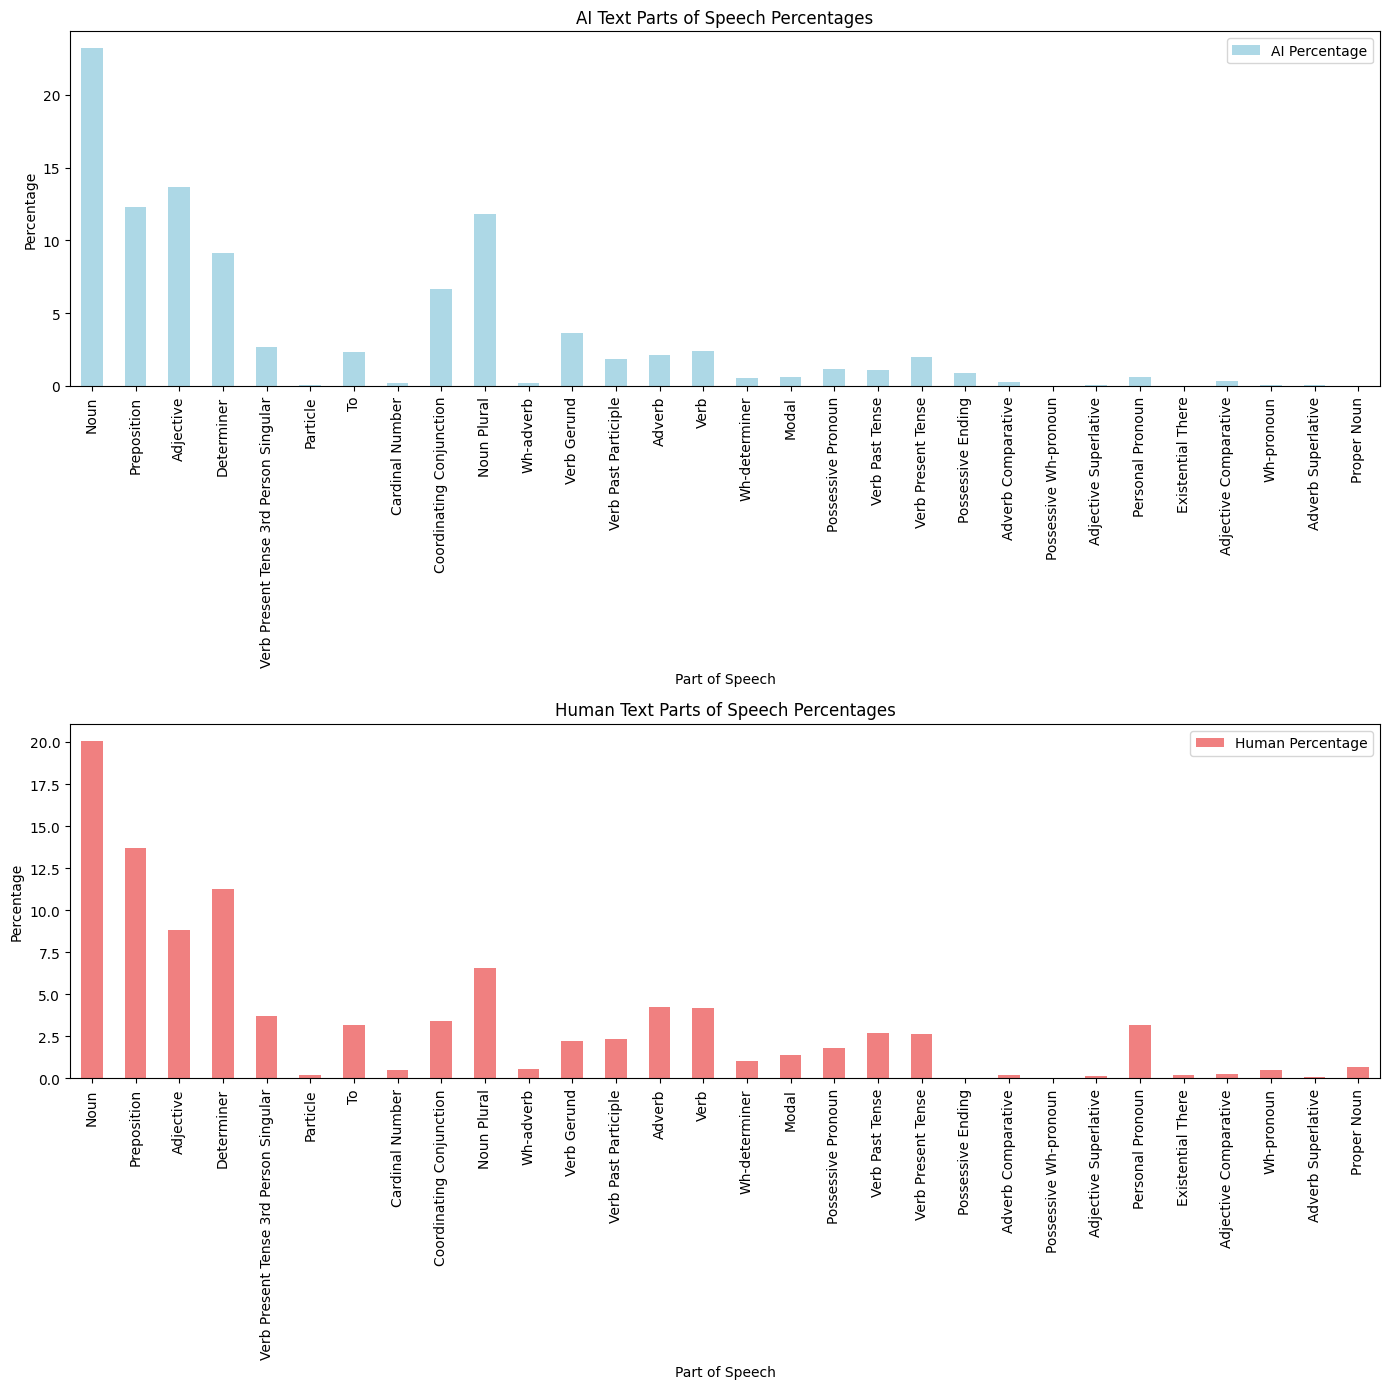

Total word count for AI essays: 44051
Total word count for Human essays: 55664


In [61]:
ai_texts = " ".join(df_all_docs[df_all_docs['label'] == 'AI']['text'])
human_texts = " ".join(df_all_docs[df_all_docs['label'] == 'Human']['text'])

def calculate_pos_counts(texts):
    tokens = word_tokenize(texts.lower())
    pos_tags = pos_tag(tokens)
    pos_counts = Counter(tag for word, tag in pos_tags)
    return pos_counts, len(tokens)

ai_pos_counts, ai_total_words = calculate_pos_counts(ai_texts)
human_pos_counts, human_total_words = calculate_pos_counts(human_texts)

# Mapping of POS tags to their full names
pos_tag_names = {
    'NN': 'Noun', 'NNS': 'Noun Plural', 'NNP': 'Proper Noun', 'NNPS': 'Proper Noun Plural',
    'VB': 'Verb', 'VBD': 'Verb Past Tense', 'VBG': 'Verb Gerund', 'VBN': 'Verb Past Participle',
    'VBP': 'Verb Present Tense', 'VBZ': 'Verb Present Tense 3rd Person Singular',
    'JJ': 'Adjective', 'JJR': 'Adjective Comparative', 'JJS': 'Adjective Superlative',
    'RB': 'Adverb', 'RBR': 'Adverb Comparative', 'RBS': 'Adverb Superlative',
    'PRP': 'Personal Pronoun', 'PRP$': 'Possessive Pronoun',
    'WP': 'Wh-pronoun', 'WP$': 'Possessive Wh-pronoun',
    'DT': 'Determiner', 'CD': 'Cardinal Number', 'IN': 'Preposition',
    'MD': 'Modal', 'CC': 'Coordinating Conjunction', 'TO': 'To',
    'UH': 'Interjection', 'FW': 'Foreign Word', 'SYM': 'Symbol',
    'RP': 'Particle', 'LS': 'List Item Marker', 'POS': 'Possessive Ending',
    'PDT': 'Predeterminer', 'EX': 'Existential There', 'WDT': 'Wh-determiner',
    'WRB': 'Wh-adverb'
}

# Calculate percentages and map to names
ai_percentages = {pos_tag_names.get(tag, tag): (ai_pos_counts[tag] / ai_total_words * 100) for tag in ai_pos_counts.keys() if ai_pos_counts[tag] > 5.0}
human_percentages = {pos_tag_names.get(tag, tag): (human_pos_counts[tag] / human_total_words * 100) for tag in human_pos_counts.keys() if human_pos_counts[tag] > 2.0}

# Create a DataFrame for easier handling and plotting
pos_df = pd.DataFrame(list(ai_percentages.items()), columns=['Part of Speech', 'AI Percentage'])
pos_df['Human Percentage'] = pos_df['Part of Speech'].map(human_percentages)

# Plot bar charts for each part of speech
fig, axs = plt.subplots(2, 1, figsize=(14, 14))

pos_df.plot(x='Part of Speech', y='AI Percentage', kind='bar', ax=axs[0], color='lightblue')
axs[0].set_title('AI Text Parts of Speech Percentages')
axs[0].set_ylabel('Percentage')

pos_df.plot(x='Part of Speech', y='Human Percentage', kind='bar', ax=axs[1], color='lightcoral')
axs[1].set_title('Human Text Parts of Speech Percentages')
axs[1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

print(f"Total word count for AI essays: {ai_total_words}")
print(f"Total word count for Human essays: {human_total_words}")

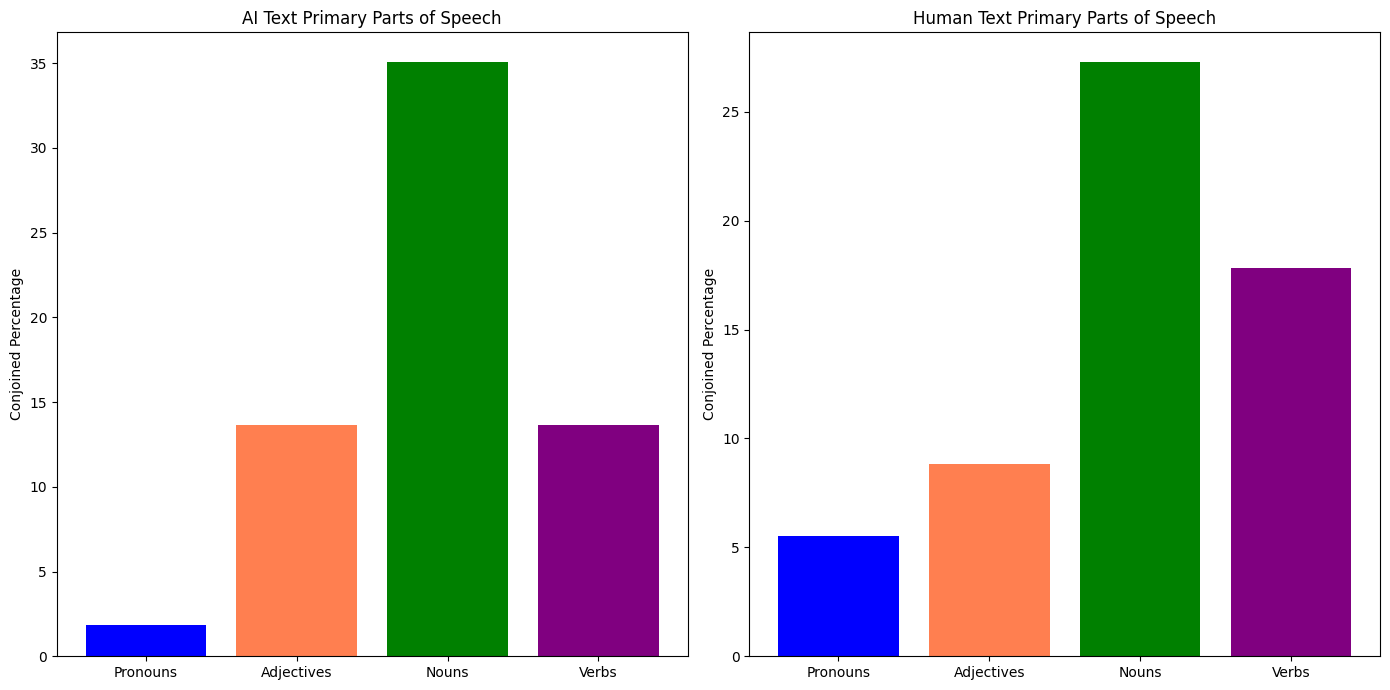

  Part of Speech  AI Frequency  Human Frequency
0       Pronouns           812             3062
1     Adjectives          6019             4912
2          Nouns         15443            15187
3          Verbs          6016             9917


In [62]:
# Calculate percentages for pronouns, adjectives, nouns, and verbs
ai_percentages = {
    'Pronouns': (ai_pos_counts['PRP'] + ai_pos_counts['PRP$'] + ai_pos_counts['WP'] + ai_pos_counts['WP$']) / ai_total_words * 100,
    'Adjectives': ai_pos_counts['JJ'] / ai_total_words * 100,
    'Nouns': (ai_pos_counts['NN'] + ai_pos_counts['NNS'] + ai_pos_counts['NNP'] + ai_pos_counts['NNPS']) / ai_total_words * 100,
    'Verbs': (ai_pos_counts['VB'] + ai_pos_counts['VBD'] + ai_pos_counts['VBG'] + ai_pos_counts['VBN'] + ai_pos_counts['VBP'] + ai_pos_counts['VBZ']) / ai_total_words * 100,
}

human_percentages = {
    'Pronouns': (human_pos_counts['PRP'] + human_pos_counts['PRP$'] + human_pos_counts['WP'] + human_pos_counts['WP$']) / human_total_words * 100,
    'Adjectives': human_pos_counts['JJ'] / human_total_words * 100,
    'Nouns': (human_pos_counts['NN'] + human_pos_counts['NNS'] + human_pos_counts['NNP'] + human_pos_counts['NNPS']) / human_total_words * 100,
    'Verbs': (human_pos_counts['VB'] + human_pos_counts['VBD'] + human_pos_counts['VBG'] + human_pos_counts['VBN'] + human_pos_counts['VBP'] + human_pos_counts['VBZ']) / human_total_words * 100,
}

labels = ['Pronouns', 'Adjectives', 'Nouns', 'Verbs']
colors = ['blue', 'coral', 'green', 'purple']
ai_values = [ai_percentages[label] for label in labels]
human_values = [human_percentages[label] for label in labels]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].bar(labels, ai_values, color=colors)
axs[0].set_title('AI Text Primary Parts of Speech')
axs[0].set_ylabel('Conjoined Percentage')

axs[1].bar(labels, human_values, color=colors)
axs[1].set_title('Human Text Primary Parts of Speech')
axs[1].set_ylabel('Conjoined Percentage')

plt.tight_layout()
plt.show()

frequency_counts = pd.DataFrame({
    'Part of Speech': labels,
    'AI Frequency': [ai_pos_counts['PRP'] + ai_pos_counts['PRP$'] + ai_pos_counts['WP'] + ai_pos_counts['WP$'], ai_pos_counts['JJ'], ai_pos_counts['NN'] + ai_pos_counts['NNS'] + ai_pos_counts['NNP'] + ai_pos_counts['NNPS'], ai_pos_counts['VB'] + ai_pos_counts['VBD'] + ai_pos_counts['VBG'] + ai_pos_counts['VBN'] + ai_pos_counts['VBP'] + ai_pos_counts['VBZ']],
    'Human Frequency': [human_pos_counts['PRP'] + human_pos_counts['PRP$'] + human_pos_counts['WP'] + human_pos_counts['WP$'], human_pos_counts['JJ'], human_pos_counts['NN'] + human_pos_counts['NNS'] + human_pos_counts['NNP'] + human_pos_counts['NNPS'], human_pos_counts['VB'] + human_pos_counts['VBD'] + human_pos_counts['VBG'] + human_pos_counts['VBN'] + human_pos_counts['VBP'] + human_pos_counts['VBZ']]
})

print(frequency_counts)

## Pronoun Analysis

Number of pronouns in AI texts: 812 (1.84%)
Number of pronouns in Human texts: 3062 (5.50%)


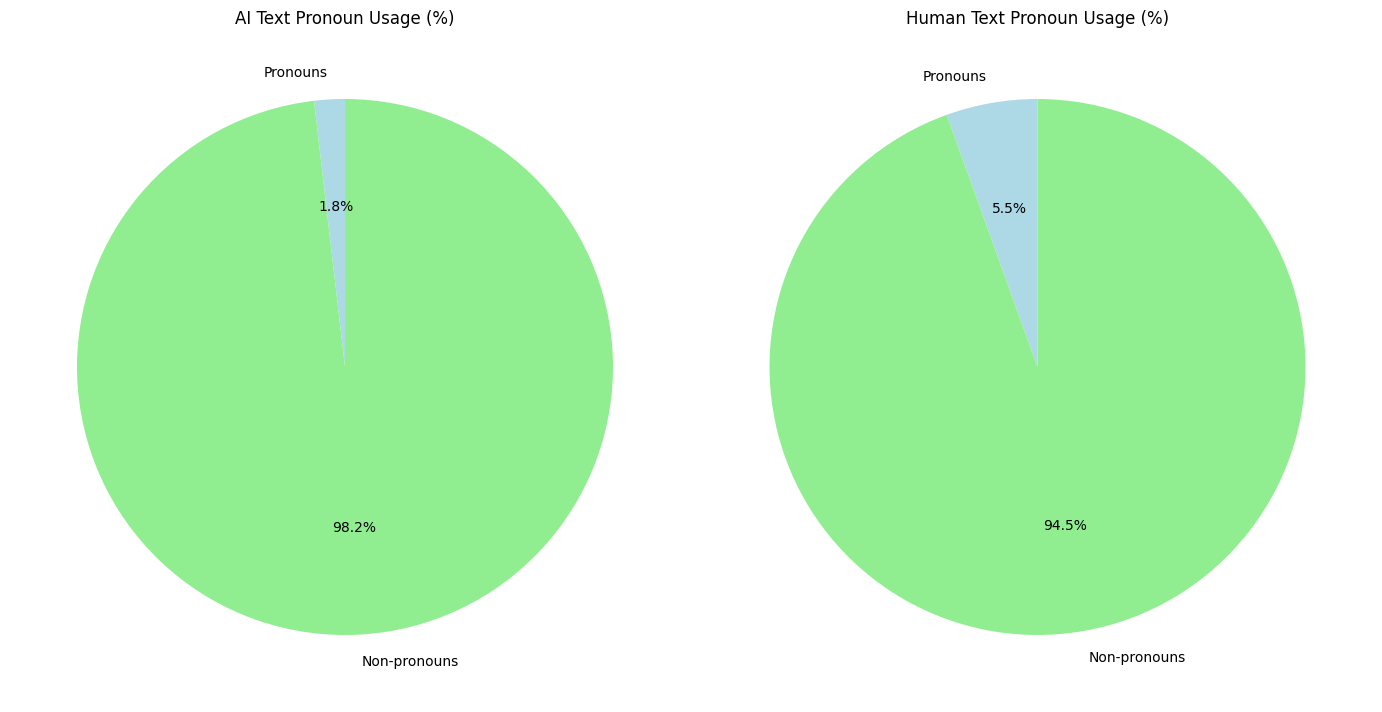

In [110]:
def calculate_pronoun_counts(texts):
    pronoun_tags = ['PRP', 'PRP$', 'WP', 'WP$']
    total_pronouns = 0
    total_words = 0
    
    for text in texts:
        words = word_tokenize(text.lower())
        tagged_words = pos_tag(words)
        total_words += len(words)
        total_pronouns += sum(1 for word, tag in tagged_words if tag in pronoun_tags)
    
    return total_pronouns, total_words

# Calculate pronoun and non-pronoun counts for AI and Human texts
ai_pronouns, ai_total_words = calculate_pronoun_counts(df_all_docs[df_all_docs['label'] == 'AI']['text'])
human_pronouns, human_total_words = calculate_pronoun_counts(df_all_docs[df_all_docs['label'] == 'Human']['text'])
ai_pronouns_percentage = (ai_pronouns / ai_total_words) * 100
human_pronouns_percentage = (human_pronouns / human_total_words) * 100


print(f"Number of pronouns in AI texts: {ai_pronouns} ({ai_pronouns_percentage:.2f}%)")
print(f"Number of pronouns in Human texts: {human_pronouns} ({human_pronouns_percentage:.2f}%)")


ai_sizes = [ai_pronouns_percentage, 100 - ai_pronouns_percentage]
human_sizes = [human_pronouns_percentage, 100 - human_pronouns_percentage]
labels = ['Pronouns', 'Non-pronouns']
colors = ['lightblue', 'lightgreen']


fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# AI Pie Chart
axs[0].pie(ai_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[0].set_title('AI Text Pronoun Usage (%)')

# Human Pie Chart
axs[1].pie(human_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Human Text Pronoun Usage (%)')

plt.tight_layout()
plt.show()

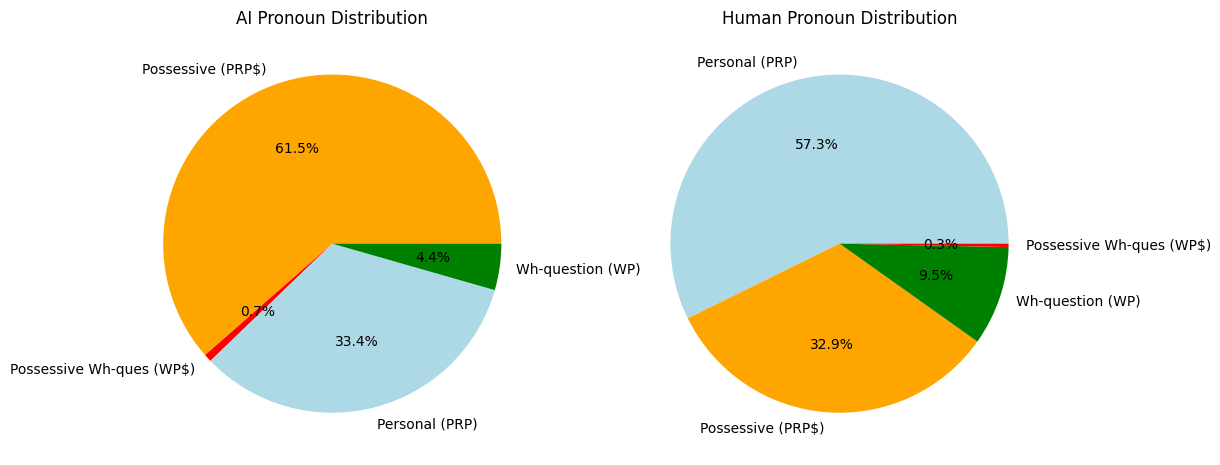

In [111]:
pronoun_tags = ['PRP', 'PRP$', 'WP', 'WP$']
tag_descriptions = {
    'PRP': 'Personal (PRP)',
    'PRP$': 'Possessive (PRP$)',
    'WP': 'Wh-question (WP)',
    'WP$': 'Possessive Wh-ques (WP$)'
}

colors = {
    'Personal (PRP)': 'lightblue',
    'Possessive (PRP$)': 'orange',
    'Wh-question (WP)': 'green',
    'Possessive Wh-ques (WP$)': 'red'
}

# Function to calculate pronoun distribution
def pronoun_distribution(texts, pronoun_tags):
    tokens = word_tokenize(texts.lower())
    tagged = pos_tag(tokens)
    pronoun_counts = Counter(tag for word, tag in tagged if tag in pronoun_tags)
    total_pronouns = sum(pronoun_counts.values())
    pronoun_percentages = {tag_descriptions[tag]: count / total_pronouns for tag, count in pronoun_counts.items() if count > 0}

    return pronoun_percentages


ai_texts = " ".join(df_all_docs[df_all_docs['label'] == 'AI']['text'])
human_texts = " ".join(df_all_docs[df_all_docs['label'] == 'Human']['text'])
ai_pronoun_distribution = pronoun_distribution(ai_texts, pronoun_tags)
human_pronoun_distribution = pronoun_distribution(human_texts, pronoun_tags)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].pie(ai_pronoun_distribution.values(), labels=ai_pronoun_distribution.keys(), autopct='%1.1f%%', colors=[colors[tag] for tag in ai_pronoun_distribution.keys()])
axs[0].set_title('AI Pronoun Distribution')

axs[1].pie(human_pronoun_distribution.values(), labels=human_pronoun_distribution.keys(), autopct='%1.1f%%', colors=[colors[tag] for tag in human_pronoun_distribution.keys()])
axs[1].set_title('Human Pronoun Distribution')

plt.show()

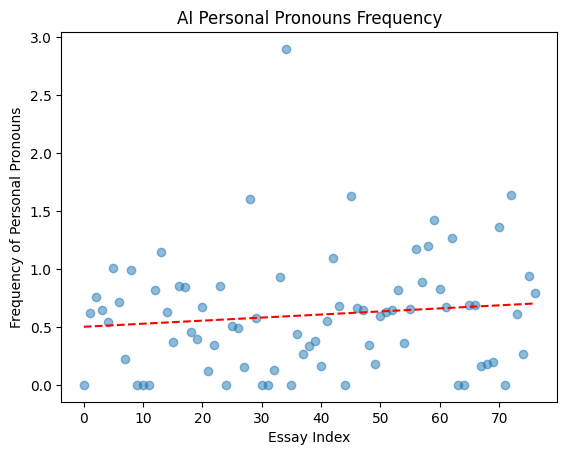

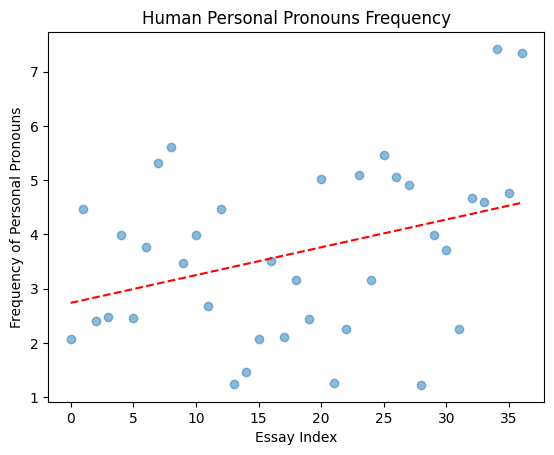

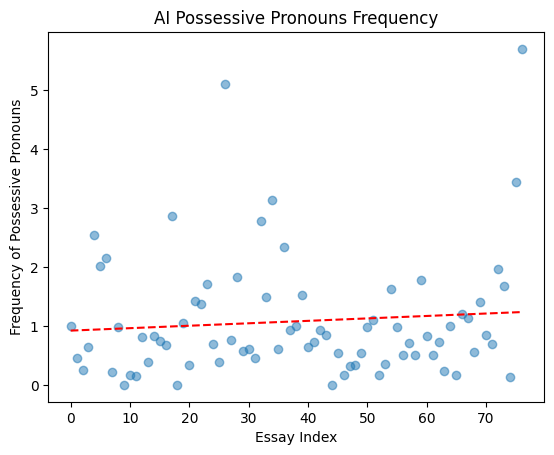

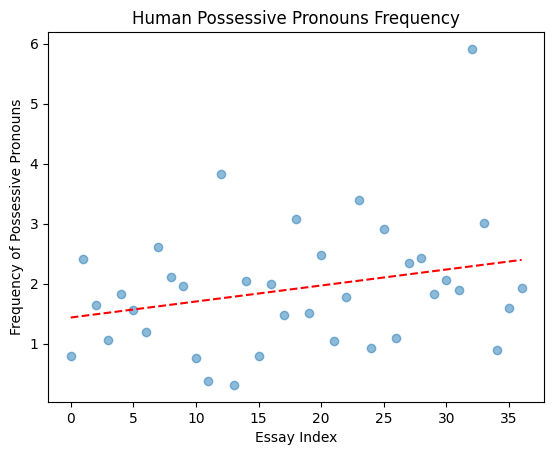

AI Personal Pronouns: Mean = 0.602, Standard Deviation = 0.499
AI Possessive Pronouns: Mean = 1.079, Standard Deviation = 1.031
Human Personal Pronouns: Mean = 3.660, Standard Deviation = 1.567
Human Possessive Pronouns: Mean = 1.916, Standard Deviation = 1.053


In [18]:
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict

def count_pronouns(texts, pronoun_tags):
    pronoun_frequencies = defaultdict(list)
    for text in texts:
        word_count = len(word_tokenize(text))
        tokens = word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        counts = Counter(tag for word, tag in pos_tags if tag in pronoun_tags)
        for tag in pronoun_tags:
            frequency = (counts.get(tag, 0) / word_count * 100) if word_count else 0
            pronoun_frequencies[tag].append(frequency)
    return pronoun_frequencies

personal_pronouns = ['PRP']
possessive_pronouns = ['PRP$']
ai_texts = df_all_docs[df_all_docs['label'] == 'AI']['text']
human_texts = df_all_docs[df_all_docs['label'] == 'Human']['text']

ai_personal_freq = count_pronouns(ai_texts, personal_pronouns)
ai_possessive_freq = count_pronouns(ai_texts, possessive_pronouns)
human_personal_freq = count_pronouns(human_texts, personal_pronouns)
human_possessive_freq = count_pronouns(human_texts, possessive_pronouns)

def plot_scatter_with_trend(x_data, y_data, title, xlabel, ylabel):
    plt.scatter(x_data, y_data, alpha=0.5)
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    plt.plot(x_data, p(x_data), "r--")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plotting the personal pronouns frequencies
plot_scatter_with_trend(
    list(range(len(ai_personal_freq['PRP']))), 
    ai_personal_freq['PRP'], 
    'AI Personal Pronouns Frequency', 
    'Essay Index', 
    'Frequency of Personal Pronouns'
)

plot_scatter_with_trend(
    list(range(len(human_personal_freq['PRP']))), 
    human_personal_freq['PRP'], 
    'Human Personal Pronouns Frequency', 
    'Essay Index', 
    'Frequency of Personal Pronouns'
)

# Plotting the possessive pronouns frequencies
plot_scatter_with_trend(
    list(range(len(ai_possessive_freq['PRP$']))), 
    ai_possessive_freq['PRP$'], 
    'AI Possessive Pronouns Frequency', 
    'Essay Index', 
    'Frequency of Possessive Pronouns'
)

plot_scatter_with_trend(
    list(range(len(human_possessive_freq['PRP$']))), 
    human_possessive_freq['PRP$'], 
    'Human Possessive Pronouns Frequency', 
    'Essay Index', 
    'Frequency of Possessive Pronouns'
)

def calculate_stats(frequencies):
    mean = np.mean(frequencies)
    std_dev = np.std(frequencies)
    return mean, std_dev

# AI Personal and Possessive Pronouns Statistics
ai_personal_mean, ai_personal_std = calculate_stats(ai_personal_freq['PRP'])
ai_possessive_mean, ai_possessive_std = calculate_stats(ai_possessive_freq['PRP$'])
# Human Personal and Possessive Pronouns Statistics
human_personal_mean, human_personal_std = calculate_stats(human_personal_freq['PRP'])
human_possessive_mean, human_possessive_std = calculate_stats(human_possessive_freq['PRP$'])

print(f"AI Personal Pronouns: Mean = {ai_personal_mean:.3f}, Standard Deviation = {ai_personal_std:.3f}")
print(f"AI Possessive Pronouns: Mean = {ai_possessive_mean:.3f}, Standard Deviation = {ai_possessive_std:.3f}")
print(f"Human Personal Pronouns: Mean = {human_personal_mean:.3f}, Standard Deviation = {human_personal_std:.3f}")
print(f"Human Possessive Pronouns: Mean = {human_possessive_mean:.3f}, Standard Deviation = {human_possessive_std:.3f}")

AI Pronoun Frequency Distribution:
<FreqDist with 23 samples and 812 outcomes>

Human Pronoun Frequency Distribution:
<FreqDist with 26 samples and 3046 outcomes>
AI Pronoun Diversity: 0.0283
Human Pronoun Diversity: 0.0085


       Pronoun  AI Count  Human Count
0          its       171           63
1        their       130          253
2           it       117          423
3          his        94          286
4          her        49          110
5         they        42          210
6          our        33          121
7          who        31          120
8           we        28          191
9           he        23          343
10          my        22          122
11        them        12           66
12          us        11           83
13      itself         9           18
14         him         9           74
15          me         9           46
16       whose         6           10
17  themselves         4           18
18        what         4          171
19      myself

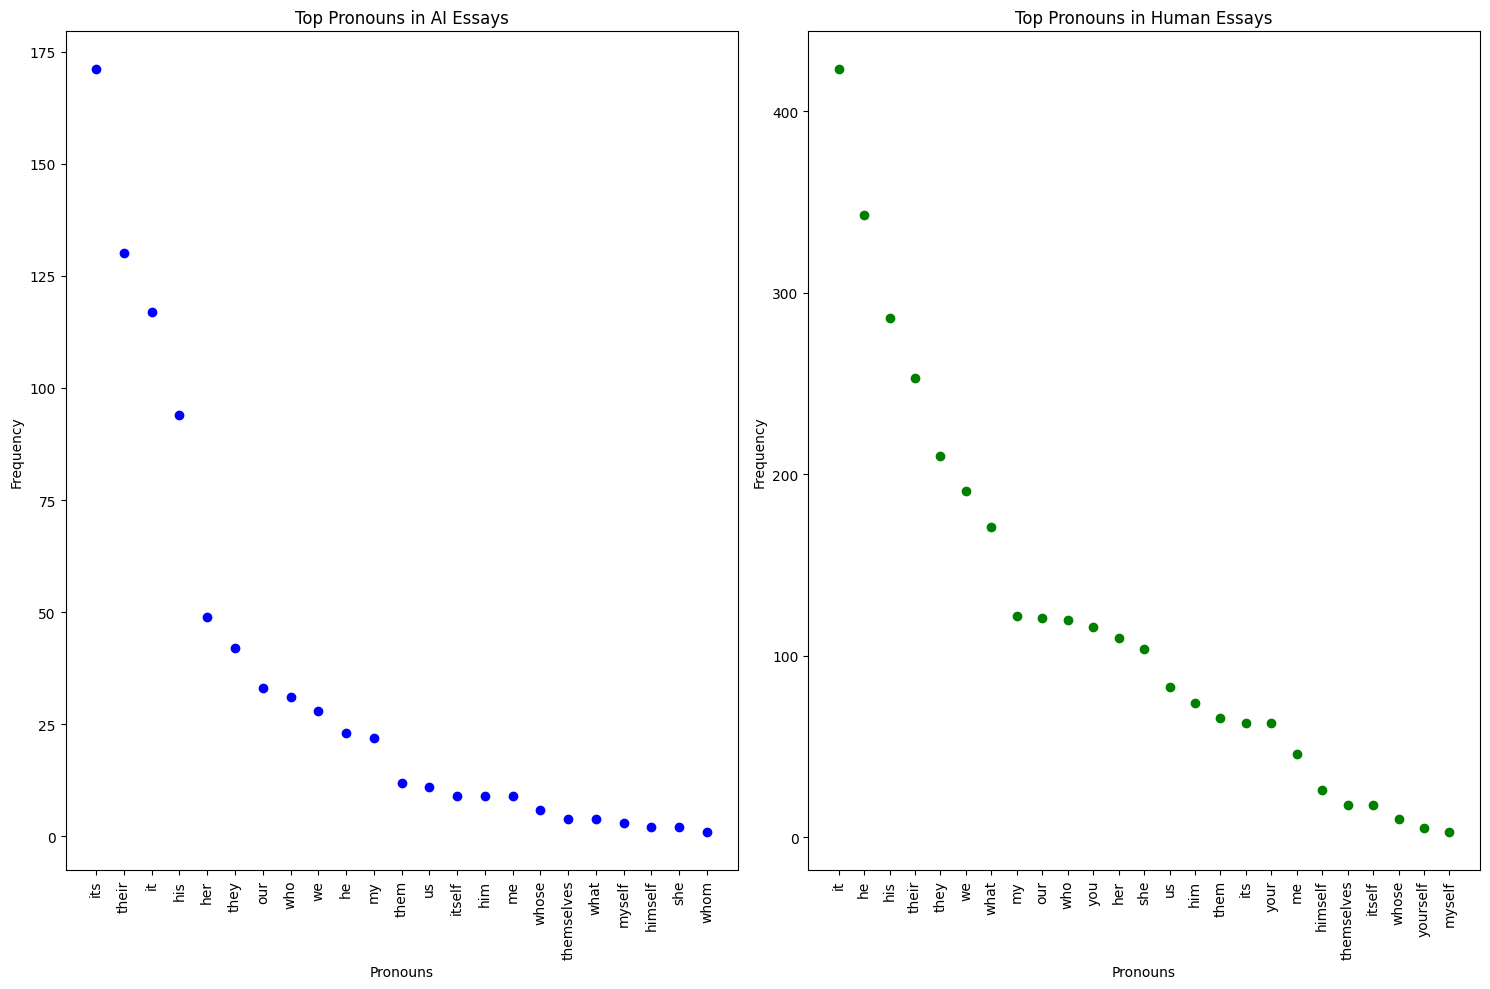

In [113]:
from nltk.text import Text

def get_text_and_tokens(df, label):
    texts = " ".join(df[df['label'] == label]['text']).lower()
    tokens = word_tokenize(texts)
    return Text(tokens), tokens

ai_text, ai_tokens = get_text_and_tokens(df_all_docs, 'AI')
human_text, human_tokens = get_text_and_tokens(df_all_docs, 'Human')

def is_pronoun(word):
    tag = nltk.pos_tag([word])[0][1]
    return tag in ['PRP', 'PRP$', 'WP', 'WP$']

ai_pronoun_freq_dist = FreqDist(word for word in ai_tokens if is_pronoun(word))
human_pronoun_freq_dist = FreqDist(word for word in human_tokens if is_pronoun(word))

print("AI Pronoun Frequency Distribution:")
print(ai_pronoun_freq_dist)
print("\nHuman Pronoun Frequency Distribution:")
print(human_pronoun_freq_dist)

total_ai_pronouns = sum(ai_pronoun_freq_dist.values())
total_human_pronouns = sum(human_pronoun_freq_dist.values())


unique_ai_pronouns = len(ai_pronoun_freq_dist)
unique_human_pronouns = len(human_pronoun_freq_dist)
# Calculate the diversity of pronoun usage
ai_pronoun_diversity = unique_ai_pronouns / total_ai_pronouns
human_pronoun_diversity = unique_human_pronouns / total_human_pronouns

print(f"AI Pronoun Diversity: {ai_pronoun_diversity:.4f}")
print(f"Human Pronoun Diversity: {human_pronoun_diversity:.4f}")

ai_pronouns_common = ai_pronoun_freq_dist.most_common()
human_pronouns_common = human_pronoun_freq_dist.most_common()

ai_pronouns_df = pd.DataFrame(ai_pronouns_common, columns=['Pronoun', 'AI Count'])
human_pronouns_df = pd.DataFrame(human_pronouns_common, columns=['Pronoun', 'Human Count'])
pronouns_comparison_df = pd.merge(ai_pronouns_df, human_pronouns_df, on='Pronoun', how='outer')

pronouns_comparison_df.fillna(0, inplace=True)
pronouns_comparison_df['AI Count'] = pronouns_comparison_df['AI Count'].astype(int)
pronouns_comparison_df['Human Count'] = pronouns_comparison_df['Human Count'].astype(int)

print('\n')
print(pronouns_comparison_df)


ai_pronouns_common = ai_pronoun_freq_dist.most_common(25)
human_pronouns_common = human_pronoun_freq_dist.most_common(25)
ai_pronouns, ai_counts = zip(*ai_pronouns_common)
human_pronouns, human_counts = zip(*human_pronouns_common)

plt.figure(figsize=(15, 10))

# AI pronouns scatter plot
plt.subplot(1, 2, 1)
plt.scatter(range(len(ai_pronouns)), ai_counts, color='blue')
plt.title('Top Pronouns in AI Essays')
plt.xlabel('Pronouns')
plt.ylabel('Frequency')
plt.xticks(range(len(ai_pronouns)), ai_pronouns, rotation=90)

# Human pronouns scatter plot
plt.subplot(1, 2, 2)
plt.scatter(range(len(human_pronouns)), human_counts, color='green')
plt.title('Top Pronouns in Human Essays')
plt.xlabel('Pronouns')
plt.ylabel('Frequency')
plt.xticks(range(len(human_pronouns)), human_pronouns, rotation=90)

plt.tight_layout()
plt.show()

## Adjective Analysis

Checking frequency of occurences of adjectives in Ai and Human text. 

JJ - General Descriptive

JJR - Adjectives Ending in "er" 

JJS - Adjectives Ending in "est"

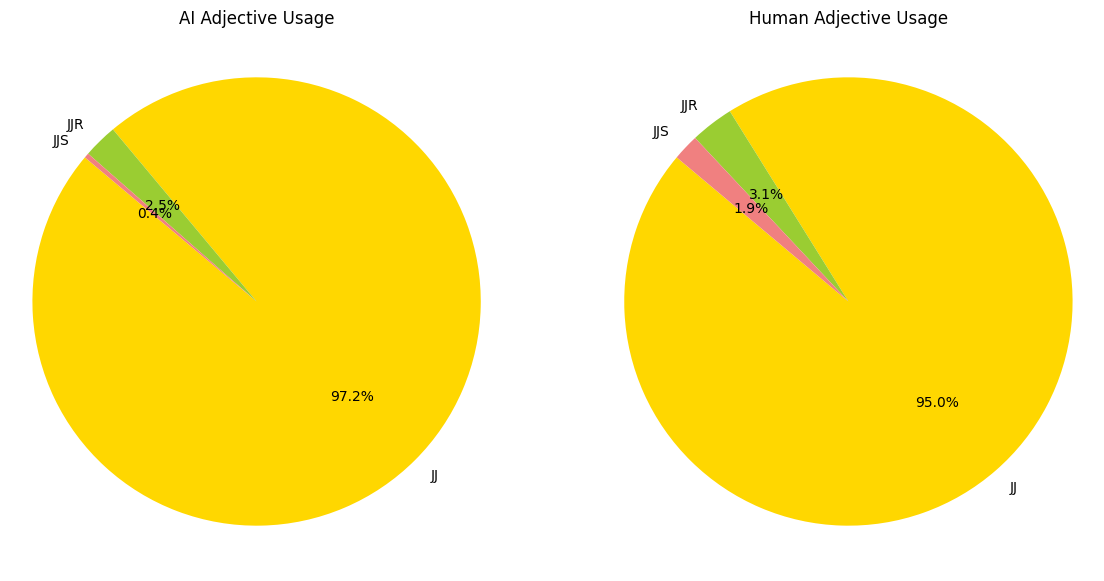

In [114]:
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as plt

# Function to get adjective counts from a text, with filtering
def get_adjective_counts(texts):
    counts = {'JJ': 0, 'JJR': 0, 'JJS': 0}
    for text in texts:
        tokens = word_tokenize(text.lower())
        # Filter out standalone apostrophes, possessive endings, and single characters
        tokens = [token for token in tokens if token not in ["'", "’"] and len(token) > 1 and not token.endswith("'s")]
        tagged_tokens = pos_tag(tokens)
        for word, tag in tagged_tokens:
            if tag in counts:
                counts[tag] += 1
    return counts

ai_essays = df_all_docs[df_all_docs['label'] == 'AI']['text']
human_essays = df_all_docs[df_all_docs['label'] == 'Human']['text']

ai_adjective_counts = get_adjective_counts(ai_essays)
human_adjective_counts = get_adjective_counts(human_essays)

# Function to plot pie chart for adjective counts
def plot_adjective_pie_chart(adjective_counts, title):
    labels = adjective_counts.keys()
    sizes = adjective_counts.values()
    colors = ['gold', 'yellowgreen', 'lightcoral']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(title)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plot_adjective_pie_chart(ai_adjective_counts, 'AI Adjective Usage')

plt.subplot(1, 2, 2)
plot_adjective_pie_chart(human_adjective_counts, 'Human Adjective Usage')

plt.show()

AI Average Adjective Occurrences: 14.68
Human Average Adjective Occurrences: 9.21

AI Average Adjective Diversity: 0.6270
Human Average Adjective Diversity: 0.6367

AI Average Adjectives per Word: 14.6815
Human Average Adjectives per Word: 9.2095


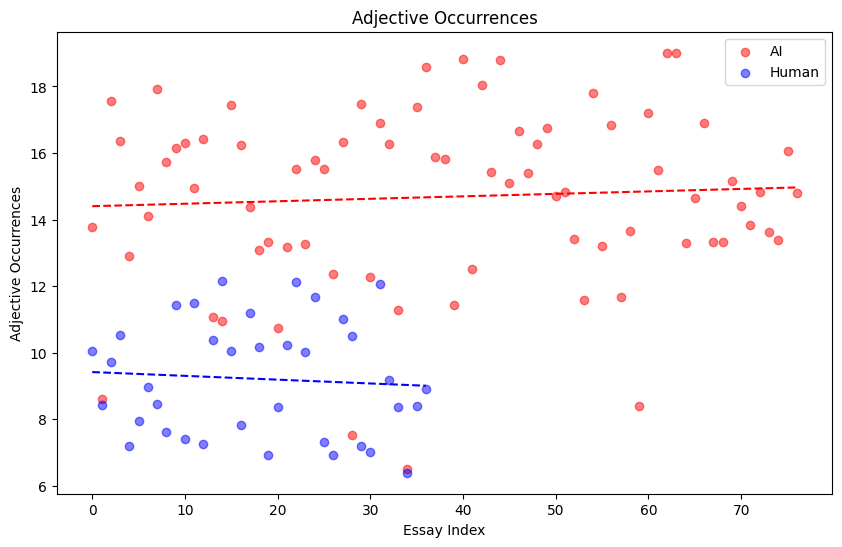

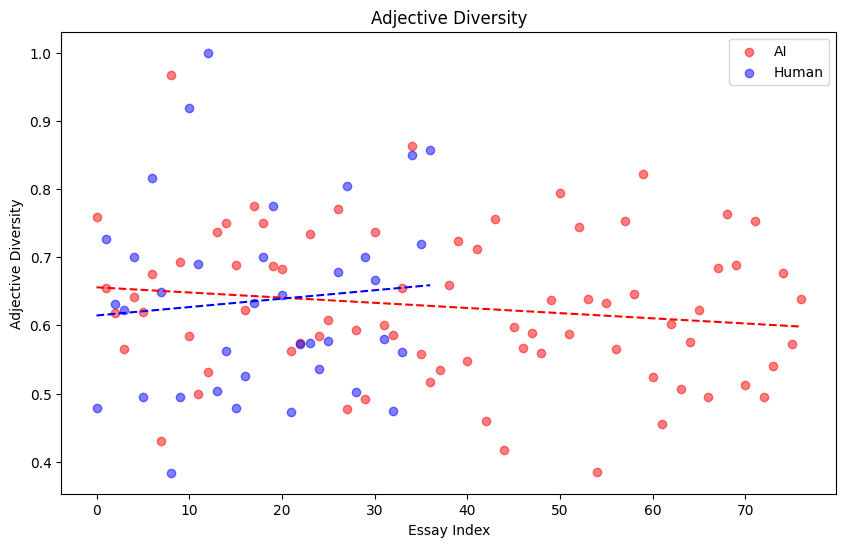

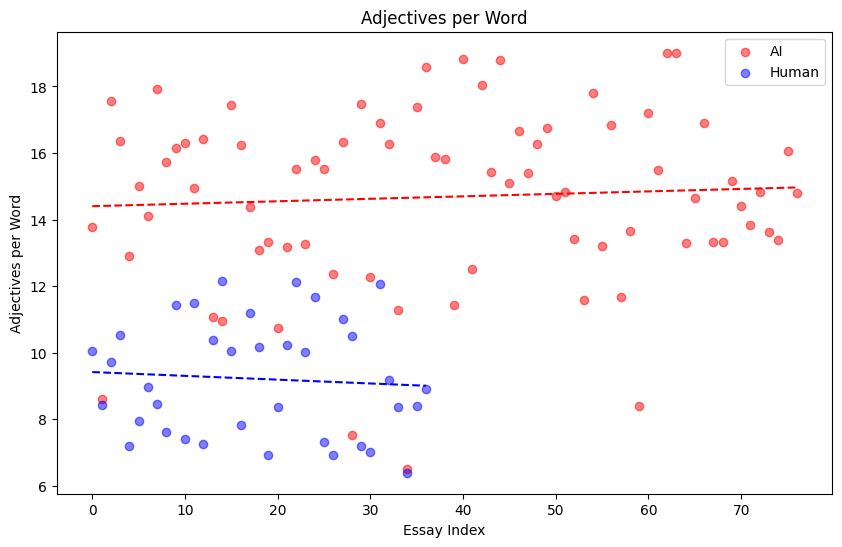

In [19]:
from nltk import pos_tag, word_tokenize
from collections import Counter
import numpy as np

def get_adjectives(text):
    tokens = word_tokenize(text.lower())  # Tokenize the text
    # Filter out standalone apostrophes, possessive endings, and single characters
    tokens = [token for token in tokens if token not in ["'", "’"] and len(token) > 1 and not token.endswith("'s")]
    tagged_tokens = pos_tag(tokens)  # Get POS tags
    adjectives = [word for word, tag in tagged_tokens if tag.startswith('JJ')]  # Select adjectives (JJ, JJR, JJS)
    return adjectives

# Function to calculate metrics for each essay
def calculate_adjective_metrics(essays):
    occurrences = []
    diversities = []
    per_word_ratios = []

    for essay in essays:
        words = word_tokenize(essay.lower())
        words = [word for word in words if word not in ["'", "’"] and len(word) > 1 and not word.endswith("'s")]
        adjectives = get_adjectives(essay)
        
        unique_adjectives = set(adjectives)
        total_adjectives = len(adjectives)
        total_words = len(words)

        occurrences.append((total_adjectives / total_words * 100) if total_words > 0 else 0) 
        diversities.append(len(unique_adjectives) / total_adjectives if total_adjectives > 0 else 0)
        per_word_ratios.append((total_adjectives / total_words * 100) if total_words > 0 else 0)  

    return occurrences, diversities, per_word_ratios

# Calculate metrics for AI and human essays
ai_occurrences, ai_diversities, ai_per_word = calculate_adjective_metrics(ai_essays)
human_occurrences, human_diversities, human_per_word = calculate_adjective_metrics(human_essays)

# Print average of each metric
print(f"AI Average Adjective Occurrences: {np.mean(ai_occurrences):.2f}")
print(f"Human Average Adjective Occurrences: {np.mean(human_occurrences):.2f}\n")
print(f"AI Average Adjective Diversity: {np.mean(ai_diversities):.4f}")
print(f"Human Average Adjective Diversity: {np.mean(human_diversities):.4f}\n")
print(f"AI Average Adjectives per Word: {np.mean(ai_per_word):.4f}")
print(f"Human Average Adjectives per Word: {np.mean(human_per_word):.4f}")

# Function to plot scatter plot with trend line for AI and Human
def plot_combined_metric_with_trend(ai_data, human_data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    ai_x_data = range(len(ai_data))
    human_x_data = range(len(human_data))
    
    # AI data
    plt.scatter(ai_x_data, ai_data, alpha=0.5, color='red', label='AI')
    ai_z = np.polyfit(ai_x_data, ai_data, 1)
    ai_p = np.poly1d(ai_z)
    plt.plot(ai_x_data, ai_p(ai_x_data), "r--")

    # Human data
    plt.scatter(human_x_data, human_data, alpha=0.5, color='blue', label='Human')
    human_z = np.polyfit(human_x_data, human_data, 1)
    human_p = np.poly1d(human_z)
    plt.plot(human_x_data, human_p(human_x_data), "b--")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot combined for Adjective Occurrences
plot_combined_metric_with_trend(ai_occurrences, human_occurrences, 'Adjective Occurrences', 'Essay Index', 'Adjective Occurrences')

# Plot combined for Adjective Diversity
plot_combined_metric_with_trend(ai_diversities, human_diversities, 'Adjective Diversity', 'Essay Index', 'Adjective Diversity')

# Plot combined for Adjectives per Word
plot_combined_metric_with_trend(ai_per_word, human_per_word, 'Adjectives per Word', 'Essay Index', 'Adjectives per Word')


In [116]:
from nltk import pos_tag, word_tokenize, FreqDist

# Function to get all adjectives from a list of texts, filtering out apostrophes and possessive endings
def get_all_adjectives(texts):
    adjectives = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token not in ["'", "’"] and len(token) > 1 and not token.endswith("'s")]
        tagged_tokens = pos_tag(tokens)
        adjectives.extend([word for word, tag in tagged_tokens if tag.startswith('JJ')])
    return adjectives

def average_adjective_length(adjectives):
    total_length = sum(len(adj) for adj in adjectives)
    return total_length / len(adjectives) if adjectives else 0

ai_essays = df_all_docs[df_all_docs['label'] == 'AI']['text']
human_essays = df_all_docs[df_all_docs['label'] == 'Human']['text']

ai_adjectives = get_all_adjectives(ai_essays)
human_adjectives = get_all_adjectives(human_essays)

ai_adjective_freq_dist = FreqDist(ai_adjectives)
human_adjective_freq_dist = FreqDist(human_adjectives)

ai_common_adjectives = ai_adjective_freq_dist.most_common(20)
human_common_adjectives = human_adjective_freq_dist.most_common(20)

print("Most common adjectives in AI essays:")
for adj, freq in ai_common_adjectives:
    print(f"{adj}: {freq}")

print("\nMost common adjectives in Human essays:")
for adj, freq in human_common_adjectives:
    print(f"{adj}: {freq}")

# Calculate and print the average adjective length
ai_avg_adj_length = average_adjective_length(ai_adjectives)
human_avg_adj_length = average_adjective_length(human_adjectives)

print(f"\nAverage adjective length in AI essays: {ai_avg_adj_length:.2f}")
print(f"Average adjective length in Human essays: {human_avg_adj_length:.2f}")

Most common adjectives in AI essays:
social: 229
human: 141
such: 119
digital: 101
global: 98
narrative: 87
cultural: 84
economic: 75
mental: 71
significant: 70
political: 69
societal: 66
complex: 65
new: 64
legal: 52
environmental: 49
critical: 48
sustainable: 48
urban: 48
moral: 47

Most common adjectives in Human essays:
other: 155
new: 81
able: 80
more: 71
such: 68
different: 68
important: 65
own: 65
many: 62
human: 57
same: 50
first: 49
legal: 37
much: 34
united: 32
personal: 32
political: 29
great: 29
white: 28
social: 27

Average adjective length in AI essays: 7.73
Average adjective length in Human essays: 6.76


Overall average adjective length in AI essays: 7.72
Overall average adjective length in Human essays: 6.58


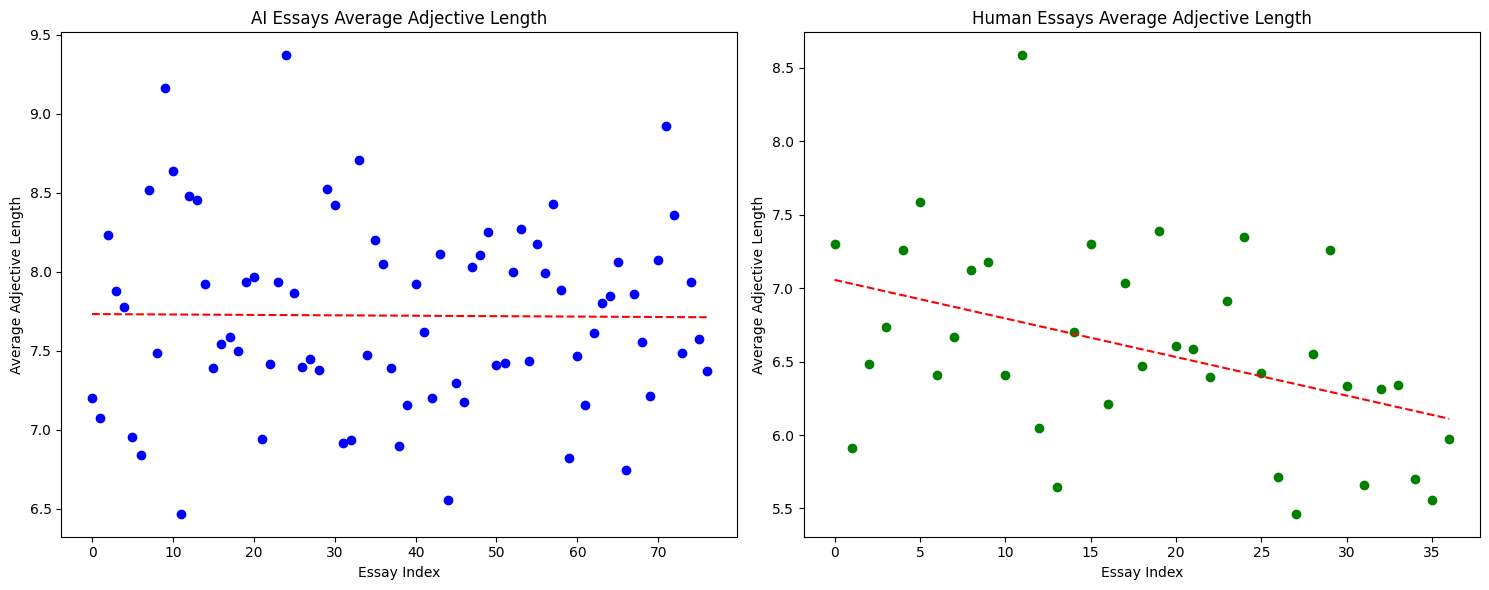

In [117]:
from nltk import word_tokenize, pos_tag
import matplotlib.pyplot as plt
import numpy as np

# Function to compute the average length of adjectives in a text
def average_adjective_length(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in ["'", "’"] and len(token) > 1 and not token.endswith("'s")]
    adjectives = [word for word, tag in pos_tag(tokens) if tag.startswith('JJ')]
    if adjectives:
        return sum(len(adj) for adj in adjectives) / len(adjectives)
    else:
        return 0

# Compute average adjective length for each AI and human essay
ai_essays = df_all_docs[df_all_docs['label'] == 'AI']['text']
human_essays = df_all_docs[df_all_docs['label'] == 'Human']['text']
ai_adjective_lengths = [average_adjective_length(essay) for essay in ai_essays]
human_adjective_lengths = [average_adjective_length(essay) for essay in human_essays]

# Calculate the overall average adjective length
ai_overall_avg_length = np.mean(ai_adjective_lengths)
human_overall_avg_length = np.mean(human_adjective_lengths)
print(f"Overall average adjective length in AI essays: {ai_overall_avg_length:.2f}")
print(f"Overall average adjective length in Human essays: {human_overall_avg_length:.2f}")

# Plotting
plt.figure(figsize=(15, 6))

# AI essays
plt.subplot(1, 2, 1)
plt.scatter(range(len(ai_adjective_lengths)), ai_adjective_lengths, color='blue', label='AI Essays')
z = np.polyfit(range(len(ai_adjective_lengths)), ai_adjective_lengths, 1)
p = np.poly1d(z)
plt.plot(range(len(ai_adjective_lengths)), p(range(len(ai_adjective_lengths))), "r--")
plt.title("AI Essays Average Adjective Length")
plt.xlabel("Essay Index")
plt.ylabel("Average Adjective Length")

# Human essays
plt.subplot(1, 2, 2)
plt.scatter(range(len(human_adjective_lengths)), human_adjective_lengths, color='green', label='Human Essays')
z = np.polyfit(range(len(human_adjective_lengths)), human_adjective_lengths, 1)
p = np.poly1d(z)
plt.plot(range(len(human_adjective_lengths)), p(range(len(human_adjective_lengths))), "r--")
plt.title("Human Essays Average Adjective Length")
plt.xlabel("Essay Index")
plt.ylabel("Average Adjective Length")

plt.tight_layout()
plt.show()

## Verb Analysis

## Punctuation Analysis

In [9]:
import string
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd

raw_ai_essays = df_all_docs[df_all_docs['label'] == 'AI']['raw_text']
raw_human_essays = df_all_docs[df_all_docs['label'] == 'Human']['raw_text']

def get_punctuation_frequencies(texts):
    punctuation_marks = set(string.punctuation)
    total_words = 0
    punctuation_counter = Counter()

    for text in texts:
        tokens = word_tokenize(text)
        total_words += len(tokens)
        punctuation_counter.update(token for token in tokens if token in punctuation_marks)
    
    return punctuation_counter, total_words

# Use the previously defined ai_essays and human_essays
ai_punctuation, ai_total_words = get_punctuation_frequencies(raw_ai_essays)
human_punctuation, human_total_words = get_punctuation_frequencies(raw_human_essays)

# Calculate normalized frequencies (per 1000 words)
ai_punct_freq = {punct: (count / ai_total_words * 100) for punct, count in ai_punctuation.items()}
human_punct_freq = {punct: (count / human_total_words * 100) for punct, count in human_punctuation.items()}

# Create a DataFrame for easy comparison
punct_freq_df = pd.DataFrame([ai_punct_freq, human_punct_freq], index=['AI', 'Human']).T
punct_freq_df = punct_freq_df.sort_values(by='AI', ascending=False)

print(punct_freq_df)

         AI     Human
,  7.901132  5.477520
.  3.652908  3.291857
(  0.113035  0.717171
)  0.113035  0.717171
'  0.096080  0.004454
:  0.030143  0.268753
;  0.024491  0.219754
#  0.005652  0.010394
%  0.003768  0.011879
!  0.001884  0.019303
?       NaN  0.149967
[       NaN  0.046030
]       NaN  0.046030
$       NaN  0.023757
|       NaN  0.001485
-       NaN  0.001485
&       NaN  0.066817
~       NaN  0.001485
/       NaN  0.004454


## Readability Scores Analysis

## Named Entity Recognition (NER)

## Feature Extraction

In [4]:
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import numpy as np

df_all_docs = pd.DataFrame(all_docs_data)

# Function to get adjectives from a text
def get_adjectives(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in ["'", "’"] and len(token) > 1 and not token.endswith("'s")]
    tagged_tokens = pos_tag(tokens)
    return [word for word, tag in tagged_tokens if tag.startswith('JJ')]

# Calculate adjective metrics
def calculate_adjective_metrics(texts):
    occurrences = []
    diversities = []
    per_word_ratios = []

    for text in texts:
        adjectives = get_adjectives(text)
        words = word_tokenize(text.lower())
        unique_adjectives = set(adjectives)

        occurrences.append(len(adjectives))
        diversities.append(len(unique_adjectives) / len(adjectives) if adjectives else 0)
        per_word_ratios.append(len(adjectives) / len(words) if words else 0)

    return occurrences, diversities, per_word_ratios

def lexical_diversity(text):
    tokens = word_tokenize(text.lower())
    unique_words = set(tokens)
    return len(unique_words) / len(tokens) if tokens else 0

def average_word_length(text):
    words = word_tokenize(text.lower())
    return np.mean([len(word) for word in words]) if words else 0

def stopword_frequency(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    stopword_count = sum(token in stop_words for token in tokens)
    return stopword_count / len(tokens) if tokens else 0

def pronoun_usage(text):
    tokens = word_tokenize(text.lower())
    tagged_tokens = pos_tag(tokens)
    personal_pronouns = sum(1 for word, tag in tagged_tokens if tag == 'PRP')
    possessive_pronouns = sum(1 for word, tag in tagged_tokens if tag == 'PRP$')
    return personal_pronouns / len(tokens), possessive_pronouns / len(tokens)

ai_texts = df_all_docs[df_all_docs['label'] == 'AI']['text']
human_texts = df_all_docs[df_all_docs['label'] == 'Human']['text']

ai_occurrences, ai_diversities, ai_per_word = calculate_adjective_metrics(ai_texts)
human_occurrences, human_diversities, human_per_word = calculate_adjective_metrics(human_texts)

# Create DataFrame 
features_df = pd.DataFrame()

features_df['adjective_occurrence'] = ai_occurrences + human_occurrences
features_df['adjective_diversity'] = ai_diversities + human_diversities
features_df['adjectives_per_word'] = ai_per_word + human_per_word
features_df['lexical_diversity'] = df_all_docs['text'].apply(lexical_diversity)
features_df['average_word_length'] = df_all_docs['text'].apply(average_word_length)
features_df['stopword_frequency'] = df_all_docs['text'].apply(stopword_frequency)

personal_pronouns, possessive_pronouns = zip(*df_all_docs['text'].apply(pronoun_usage))
features_df['personal_pronouns'] = personal_pronouns
features_df['possessive_pronouns'] = possessive_pronouns

features_df['label'] = df_all_docs['label']
display(features_df.head())

,adjective_occurrence,adjective_diversity,adjectives_per_word,lexical_diversity,average_word_length,stopword_frequency,personal_pronouns,possessive_pronouns,label
0,54,0.759259,0.134328,0.265504,5.057032,0.455703,0.020764,0.008029,Human
1,55,0.654545,0.084746,0.394454,4.503578,0.483005,0.044723,0.024150,Human
2,68,0.617647,0.172589,0.331044,5.125343,0.434409,0.024038,0.016484,Human
3,99,0.565657,0.159164,0.348091,5.057271,0.435418,0.024777,0.010561,Human
4,67,0.641791,0.121597,0.336806,4.859375,0.493056,0.039931,0.018229,Human


# Random Forest Implementation

Accuracy: 0.9565217391304348
              precision    recall  f1-score   support

          AI       0.94      1.00      0.97        15
       Human       1.00      0.88      0.93         8

    accuracy                           0.96        23
   macro avg       0.97      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23

Feature importances:
                feature  importance
5    stopword_frequency    0.312377
6     personal_pronouns    0.277272
4   average_word_length    0.200984
3     lexical_diversity    0.107921
7   possessive_pronouns    0.062326
0  adjective_occurrence    0.018922
2   adjectives_per_word    0.013053
1   adjective_diversity    0.007145


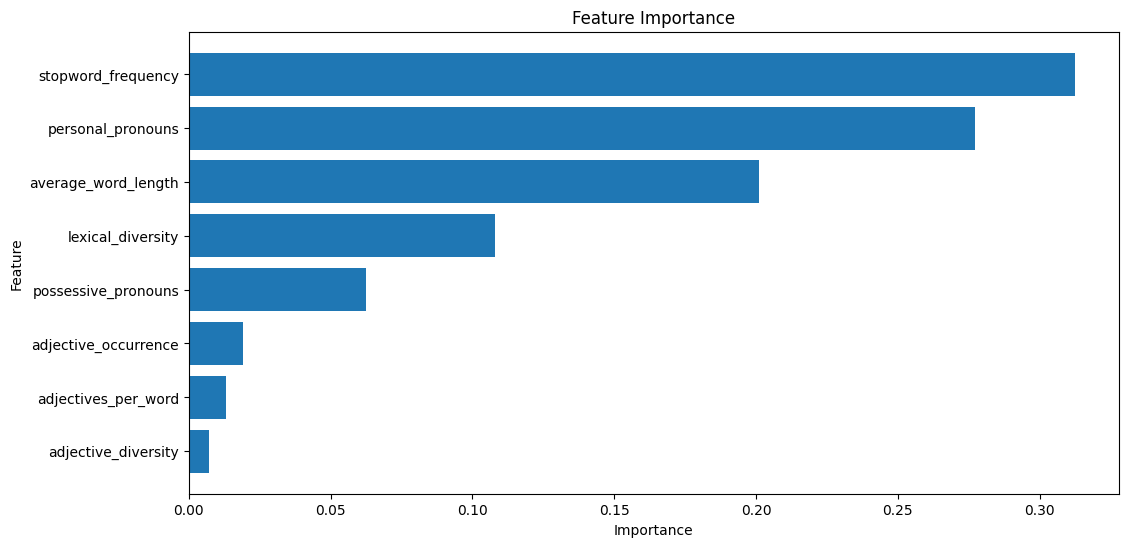

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = features_df.drop('label', axis=1)  # Feature matrix
y = features_df['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

importances = rf_model.feature_importances_


feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Display the sorted feature importances
print("Feature importances:")
print(feature_importances_sorted)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances_sorted['feature'], feature_importances_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [120]:
def extract_features(text):
    
    adjectives = get_adjectives(text)
    words = word_tokenize(text.lower())
    unique_adjectives = set(adjectives)
    
    # Calculate features
    adjective_occurrence = len(adjectives)
    adjective_diversity = len(unique_adjectives) / len(adjectives) if adjectives else 0
    adjectives_per_word = len(adjectives) / len(words) if words else 0
    lexical_div = lexical_diversity(text)
    avg_word_length = average_word_length(text)
    stopword_freq = stopword_frequency(text)
    personal_pronoun, possessive_pronoun = pronoun_usage(text)

    features = {
        'adjective_occurrence': adjective_occurrence,
        'adjective_diversity': adjective_diversity,
        'adjectives_per_word': adjectives_per_word,
        'lexical_diversity': lexical_div,
        'average_word_length': avg_word_length,
        'stopword_frequency': stopword_freq,
        'personal_pronouns': personal_pronoun,
        'possessive_pronouns': possessive_pronoun
    }
    
    return features

def predict_label(text, model):
    
    #extracts the necessary features from the text
    features = extract_features(text)
    features_df = pd.DataFrame([features])

    prediction = model.predict(features_df)
    return prediction[0]

def read_docx(file_path):
    doc = docx.Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

def predict_label_from_file(file_path, model):
    text = read_docx(file_path)
    return predict_label(text, model)

file_path = r'C:\Users\Colin\OneDrive\Desktop\Senior Project Code\Senior-Project\Test Essay\ai_test.docx'
prediction = predict_label_from_file(file_path, rf_model)

print("Predicted label:", prediction)

Predicted label: AI
